![image-2.png](attachment:image-2.png)

## This final project focuses on leveraging the techniques and concepts you've learned throughout this course.
- You will apply image processing, feature extraction, and pattern recognition methods to solve real-world challenges. Specifically, you will implement and fine-tune state-of-the-art algorithms like Convolutional Neural Networks (CNNs), object detection, image segmentation, or even feature matching.

we'll build a CNN using Keras to use it classifying thousands of pictures in six different categories

Data link : https://www.kaggle.com/puneet6060/intel-image-classification

#Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import glob as gb
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from tqdm import tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support

#define the path ( to swtich it between jupyter notebook & kaggle kernel)

In [2]:
# train_path='seg_train/seg_train'
# test_path='seg_test/seg_test'
# pred_path='seg_pred/seg_pred'

train_path='D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/Intel Image Classification Dataset/seg_train/seg_train'
test_path='D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/Intel Image Classification Dataset/seg_test/seg_test'
pred_path='D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/Intel Image Classification Dataset/seg_pred/seg_pred'

In [3]:
os.listdir(train_path)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Open Folders

now let's first check the Train folder to have a look to its content

In [5]:
def count_images_in_folders(base_path, description , is_subfolder = True):
    """
    Counts and prints the number of images in each folder within the specified base path.

    Parameters:
    - base_path: The path containing subfolders with images.
    - description: A string describing the type of data (e.g., 'training', 'testing', or 'prediction').
    """
    if is_subfolder:
        for folder in os.listdir(base_path):
            folder_path = os.path.join(base_path, folder)
            images = gb.glob(os.path.join(folder_path, '*.jpg'))
            print(f'For {description} data, found {len(images)} images in folder "{folder}".')
    else:
        images = gb.glob(pathname=os.path.join(base_path, '*.jpg'))
        print(f'For {description} data, found {len(images)} images.')


# Count images in training, testing, and prediction data
count_images_in_folders(train_path, 'training' , is_subfolder = True)
count_images_in_folders(test_path, 'testing', is_subfolder = True)
count_images_in_folders(pred_path, 'prediction' , is_subfolder = False)

For training data, found 2191 images in folder "buildings".
For training data, found 2271 images in folder "forest".
For training data, found 2404 images in folder "glacier".
For training data, found 2512 images in folder "mountain".
For training data, found 2274 images in folder "sea".
For training data, found 2382 images in folder "street".
For testing data, found 437 images in folder "buildings".
For testing data, found 474 images in folder "forest".
For testing data, found 553 images in folder "glacier".
For testing data, found 525 images in folder "mountain".
For testing data, found 510 images in folder "sea".
For testing data, found 501 images in folder "street".
For prediction data, found 7301 images.


#Checking Images
now we need to check the images sizes , to know ow they looks like

since we have 6 categories , we first need to create a dictionary with their names & indices , also create a function to get the code back

In [4]:
code = {'buildings':0 ,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}

def get_code(n):
    for x,y in code.items():
        if n==y:
            return x
get_code(3)

'mountain'

In [7]:
def get_image_sizes(image_path, is_subfolder=False):
    """
    This function calculates the sizes of images in the given path.

    Parameters:
    - image_path: Path where images are stored.
    - is_subfolder: Set to True if the images are in subfolders (like train/test sets).

    Returns:
    - A pandas Series with the count of each image size.
    """
    sizes = []

    if is_subfolder:
        for folder in os.listdir(image_path):
            images = gb.glob(pathname=str(image_path + '/' + folder + '/*.jpg'))
            for img in images:
                image = plt.imread(img)
                sizes.append(image.shape)
    else:
        files = gb.glob(pathname=str(image_path + '/*.jpg'))
        for file in files:
            image = plt.imread(file)
            sizes.append(image.shape)

    return pd.Series(sizes).value_counts()

# Usage examples
train_sizes = get_image_sizes(train_path, is_subfolder=True)
test_sizes = get_image_sizes(test_path, is_subfolder=True)
pred_sizes = get_image_sizes(pred_path, is_subfolder=False)

print("Train Image Sizes:\n", train_sizes)
print("Test Image Sizes:\n", test_sizes)
print("Prediction Image Sizes:\n", pred_sizes)

Train Image Sizes:
 (150, 150, 3)    13986
(113, 150, 3)        7
(111, 150, 3)        3
(135, 150, 3)        3
(144, 150, 3)        2
(123, 150, 3)        2
(142, 150, 3)        2
(146, 150, 3)        2
(143, 150, 3)        2
(134, 150, 3)        2
(136, 150, 3)        2
(108, 150, 3)        2
(105, 150, 3)        1
(97, 150, 3)         1
(131, 150, 3)        1
(147, 150, 3)        1
(81, 150, 3)         1
(145, 150, 3)        1
(141, 150, 3)        1
(100, 150, 3)        1
(103, 150, 3)        1
(76, 150, 3)         1
(120, 150, 3)        1
(102, 150, 3)        1
(119, 150, 3)        1
(133, 150, 3)        1
(115, 150, 3)        1
(124, 150, 3)        1
(110, 150, 3)        1
(149, 150, 3)        1
(140, 150, 3)        1
Name: count, dtype: int64
Test Image Sizes:
 (150, 150, 3)    2993
(141, 150, 3)       1
(110, 150, 3)       1
(76, 150, 3)        1
(149, 150, 3)       1
(72, 150, 3)        1
(131, 150, 3)       1
(81, 150, 3)        1
Name: count, dtype: int64
Prediction Image Siz

ok , since almost all of pictures are 150,150,3 , we can feel comfort in using all pictures in our model , after resizing it in a specific amount

#Reading Images
now it's time to read all images & convert it into arrays

first we'll create a variable s , which refer to size , so we can change it easily

let's use now size = 100 , so it will be suitable amount to contain accuracy without losing so much time in training

In [5]:
def load_images(image_path, code, resize_shape=(150, 150), is_subfolder=True):
    """
    Loads and resizes images from the specified path.

    Parameters:
    - image_path: Path where images are stored.
    - code: A dictionary mapping folder names to labels.
    - resize_shape: Tuple specifying the new size for resizing images (default is (150, 150)).
    - is_subfolder: Boolean indicating if images are in subfolders (True for train/test, False for prediction).

    Returns:
    - x_data: A NumPy array of resized images.
    - y_data: Corresponding labels (if applicable, else returns None for prediction data).
    """
    x_data = []
    y_data = []

    if is_subfolder:
        for folder in os.listdir(image_path):
            folder_path = os.path.join(image_path, folder)
            images = gb.glob(pathname=os.path.join(folder_path, '*.jpg'))
            for img_path in images:
                image = plt.imread(img_path)  # Alternatively, you can use cv2.imread for BGR images
                image_resized = cv2.resize(image, resize_shape)
                x_data.append(image_resized)
                y_data.append(code[folder])  # Append the folder's label
    else:
        images = gb.glob(pathname=os.path.join(image_path, '*.jpg'))
        for img_path in images:
            image = cv2.imread(img_path)
            image_resized = cv2.resize(image, resize_shape)
            x_data.append(image_resized)
        y_data = None  # No labels for prediction data

    return np.array(x_data), np.array(y_data)

# Usage for train data
x_train, y_train = load_images(train_path, code, resize_shape=(100, 100), is_subfolder=True)

# Usage for test data
x_test, y_test = load_images(test_path, code, resize_shape=(100, 100), is_subfolder=True)

# Usage for prediction data (no labels)
x_pred, _ = load_images(pred_path, code=None, resize_shape=(100, 100), is_subfolder=False)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")
print(f"x_pred shape: {x_pred.shape}")

x_train shape: (14034, 100, 100, 3), y_train shape: (14034,)
x_test shape: (3000, 100, 100, 3), y_test shape: (3000,)
x_pred shape: (7301, 100, 100, 3)


In [6]:
## Shuffling data
import random

indices = np.arange(len(x_train))
random.seed(42)
random.shuffle(indices)
print(indices.shape)
print(indices)

x_train = x_train[indices]
y_train = y_train[indices]

indices2 = np.arange(len(x_test))
random.shuffle(indices2)

x_test = x_test[indices2]
y_test = y_test[indices2]


(14034,)
[ 9967  2376  1694 ...   409  1824 10476]


In [7]:
## COPY OF DATA
x_train_copy , y_train_copy = x_train , y_train
x_test_copy , y_test_copy = x_test, y_test
x_pred_copy = x_pred

print(x_train_copy.shape)
print(y_train_copy.shape)

print(x_test_copy.shape)
print(y_test_copy.shape)

print(x_pred_copy.shape)

(14034, 100, 100, 3)
(14034,)
(3000, 100, 100, 3)
(3000,)
(7301, 100, 100, 3)


In [8]:
x_train , y_train = x_train_copy , y_train_copy
x_test, y_test = x_test_copy , y_test_copy
x_pred = x_pred_copy

x_train=np.array(x_train)[:10000]
x_test=np.array(x_test)[:2500]

y_train=np.array(y_train)[:10000]
y_test=np.array(y_test)[:2500]

x_pred=np.array(x_pred)[:2500]

print(x_train.shape)
print(x_test.shape)

print(y_train.shape)
print(y_test.shape)

print(x_pred.shape)

# Create generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
      rescale=1.0/255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      brightness_range=(0.5,1.5),
      fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
      rescale=1.0/255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      brightness_range=(0.5,1.5),
      fill_mode='nearest'
)


train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=32
)

val_generator = val_datagen.flow(
    x_test,
    y_test,
    batch_size=32
)

print("\n" , "After Image Generator:")
print(x_train.shape)
print(x_test.shape)

print(y_train.shape)
print(y_test.shape)

(10000, 100, 100, 3)
(2500, 100, 100, 3)
(10000,)
(2500,)
(2500, 100, 100, 3)

 After Image Generator:
(10000, 100, 100, 3)
(2500, 100, 100, 3)
(10000,)
(2500,)


In [22]:
'''''
#implement same as vgg16
KerasModel = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(200, activation='tanh', kernel_size=(3,3), padding='same', input_shape=(100,100,3)),
    tf.keras.layers.Conv2D(180, activation='tanh', kernel_size=(3,3), padding='same'),
    tf.keras.layers.Conv2D(160, activation='tanh', kernel_size=(3,3), padding='same'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(140, activation='tanh', kernel_size=(3,3), padding='same'),
    tf.keras.layers.Conv2D(120, activation='tanh', kernel_size=(3,3), padding='same'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(100, activation='tanh', kernel_size=(3,3), padding='same'),
    tf.keras.layers.Conv2D(80, activation='tanh', kernel_size=(3,3), padding='same'),
    tf.keras.layers.Conv2D(60, activation='tanh', kernel_size=(3,3), padding='same'),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(140, activation='tanh', kernel_size=(3,3), padding='same'),
    tf.keras.layers.Conv2D(120, activation='tanh', kernel_size=(3,3), padding='same'),
    tf.keras.layers.MaxPool2D((2, 2)),

    tf.keras.layers.Conv2D(50, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.Conv2D(40, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.Conv2D(40, activation='relu', kernel_size=(3,3), padding='same'),
    tf.keras.layers.Conv2D(30, activation='relu', kernel_size=(3,3), padding='same'),

    tf.keras.layers.Conv2D(20, activation='relu', kernel_size=(3,3), padding='same'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(30, activation='tanh'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])
'''''

"''\n#implement same as vgg16\nKerasModel = tf.keras.models.Sequential([\n    tf.keras.layers.Conv2D(200, activation='tanh', kernel_size=(3,3), padding='same', input_shape=(100,100,3)),\n    tf.keras.layers.Conv2D(180, activation='tanh', kernel_size=(3,3), padding='same'),\n    tf.keras.layers.Conv2D(160, activation='tanh', kernel_size=(3,3), padding='same'),\n    tf.keras.layers.MaxPool2D((2, 2)),\n    tf.keras.layers.Conv2D(140, activation='tanh', kernel_size=(3,3), padding='same'),\n    tf.keras.layers.Conv2D(120, activation='tanh', kernel_size=(3,3), padding='same'),\n    tf.keras.layers.MaxPool2D((2, 2)),\n    tf.keras.layers.Conv2D(100, activation='tanh', kernel_size=(3,3), padding='same'),\n    tf.keras.layers.Conv2D(80, activation='tanh', kernel_size=(3,3), padding='same'),\n    tf.keras.layers.Conv2D(60, activation='tanh', kernel_size=(3,3), padding='same'),\n    tf.keras.layers.MaxPool2D((2, 2)),\n    tf.keras.layers.Conv2D(140, activation='tanh', kernel_size=(3,3), padding='

## MY OWN MODEL

In [40]:
### implement my model

KerasModel = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(60, activation='relu', kernel_size=(3,3), padding='same',  input_shape=(100,100,3)),
    tf.keras.layers.Conv2D(60, activation='relu', kernel_size=(3,3), padding='same', ),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(120, activation='relu', kernel_size=(3,3), padding='same' ),
    tf.keras.layers.Conv2D(120, activation='relu', kernel_size=(3,3), padding='same' ),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(240, activation='relu', kernel_size=(3,3), padding='same' ),
    tf.keras.layers.Conv2D(240, activation='relu', kernel_size=(3,3), padding='same' ),
    tf.keras.layers.Conv2D(240, activation='relu', kernel_size=(3,3), padding='same' ),
    # tf.keras.layers.Conv2D(240, activation='relu', kernel_size=(3,3), padding='same' ),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(480, activation='relu', kernel_size=(3,3), padding='same' ),
    tf.keras.layers.Conv2D(480, activation='relu', kernel_size=(3,3), padding='same' ),
    tf.keras.layers.Conv2D(480, activation='relu', kernel_size=(3,3), padding='same' ),
    # tf.keras.layers.Conv2D(480, activation='relu', kernel_size=(3,3), padding='same' ),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(600, activation='relu', kernel_size=(3,3), padding='same' ),
    tf.keras.layers.Conv2D(600, activation='relu', kernel_size=(3,3), padding='same' ),
    tf.keras.layers.Conv2D(600, activation='relu', kernel_size=(3,3), padding='same' ),
    # tf.keras.layers.Conv2D(600, activation='relu', kernel_size=(3,3), padding='same' ),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2, 2)),
    # tf.keras.layers.Conv2D(900, activation='relu', kernel_size=(3,3), padding='same' ),
    # tf.keras.layers.Conv2D(900, activation='relu', kernel_size=(3,3), padding='same' ),
    # tf.keras.layers.Conv2D(900, activation='relu', kernel_size=(3,3), padding='same' ),
    # tf.keras.layers.Conv2D(900, activation='relu', kernel_size=(3,3), padding='same' ),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.MaxPool2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [41]:
KerasModel.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [43]:
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping

# Define the path where you want to save the best model
model_save_path = 'D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/model_weights/best_model.keras'  # Specify your desired path and filename

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    model_save_path,
    monitor='val_loss',  # Monitor validation loss; change to 'val_accuracy' if desired
    save_best_only=True,  # Save only the best model
    mode='min',  # 'min' for loss, 'max' for accuracy
    verbose=1  # Verbosity mode, 1 = save messages
)
'''''
earlystopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.04,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=4
)
'''''
# Train the model with the ModelCheckpoint callback
model = KerasModel.fit(
    train_generator,
    validation_data=val_generator,  # Make sure to include validation data
    epochs=25,
    batch_size=64,
    verbose=1,
    callbacks=[checkpoint ]  # Pass the checkpoint callback here
)

Epoch 1/25


c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3187 - loss: 1.7074
Epoch 1: val_loss improved from inf to 1.70406, saving model to D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/model_weights/best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.3190 - loss: 1.7065 - val_accuracy: 0.2555 - val_loss: 1.7041
Epoch 2/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4790 - loss: 1.2736
Epoch 2: val_loss did not improve from 1.70406
250/250 ━━━━━━━━━━━━━━━━━━━━ 393s 2s/step - accuracy: 0.4790 - loss: 1.2735 - val_accuracy: 0.2780 - val_loss: 1.9963
Epoch 3/25
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4958 - loss: 1.2102
Epoch 3: val_loss improved from 1.70406 to 1.63584, saving model to D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/model_weights/best_model.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 393s 2s/step - accuracy: 0.4958 - loss: 1.2102 - val_accuracy: 0.3820 - val_loss: 1.6358
Epoch 4/25
250/250 ━━━━━━━━━━━━━━

In [44]:
KerasModel.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 100, 100, 60)   │         1,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 100, 100, 60)   │        32,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 50, 50, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 50, 50, 120)    │        64,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 50, 50, 120)    │       129,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 25, 25, 120)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 25, 25, 240)    │       259,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 25, 25, 240)    │       518,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 25, 25, 240)    │       518,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 12, 12, 240)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 12, 12, 480)    │     1,037,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 12, 12, 480)    │     2,074,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 12, 12, 480)    │     2,074,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 6, 6, 480)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 6, 6, 600)      │     2,592,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 6, 6, 600)      │     3,240,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 6, 6, 600)      │     3,240,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 3, 3, 600)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 5400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 5400)           │        21,600 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │       691,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 128)            │           51

 Total params: 49,525,312 (188.92 MB)

 Trainable params: 16,504,666 (62.96 MB)

 Non-trainable params: 11,312 (44.19 KB)

 Optimizer params: 33,009,334 (125.92 MB)

In [45]:
x_test_norm = x_test/255    ## normalization
loss,accuracy=KerasModel.evaluate(x_test_norm,y_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 381ms/step - accuracy: 0.5171 - loss: 1.3840


In [40]:
print(f'loss is {loss}')
print(f'accuracy is {accuracy}')

loss is 0.6458274126052856
accuracy is 0.7613333463668823


In [13]:
x_pred_norm = x_pred/255    ## normalization
y_result = KerasModel.predict(x_pred_norm)

y_result

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 280ms/step


array([[0.11867674, 0.48609874, 0.06235908, 0.01766325, 0.05402263,
        0.26117948],
       [0.003955  , 0.00557607, 0.05767093, 0.4495568 , 0.47863847,
        0.00460279],
       [0.20603761, 0.00393108, 0.02636159, 0.01014227, 0.02428411,
        0.72924334],
       ...,
       [0.29498702, 0.05093858, 0.08129735, 0.11302929, 0.16237162,
        0.29737616],
       [0.26614273, 0.00644075, 0.01933954, 0.09627851, 0.21509667,
        0.39670193],
       [0.05732593, 0.00669512, 0.16418733, 0.06041127, 0.20446402,
        0.50691634]], dtype=float32)

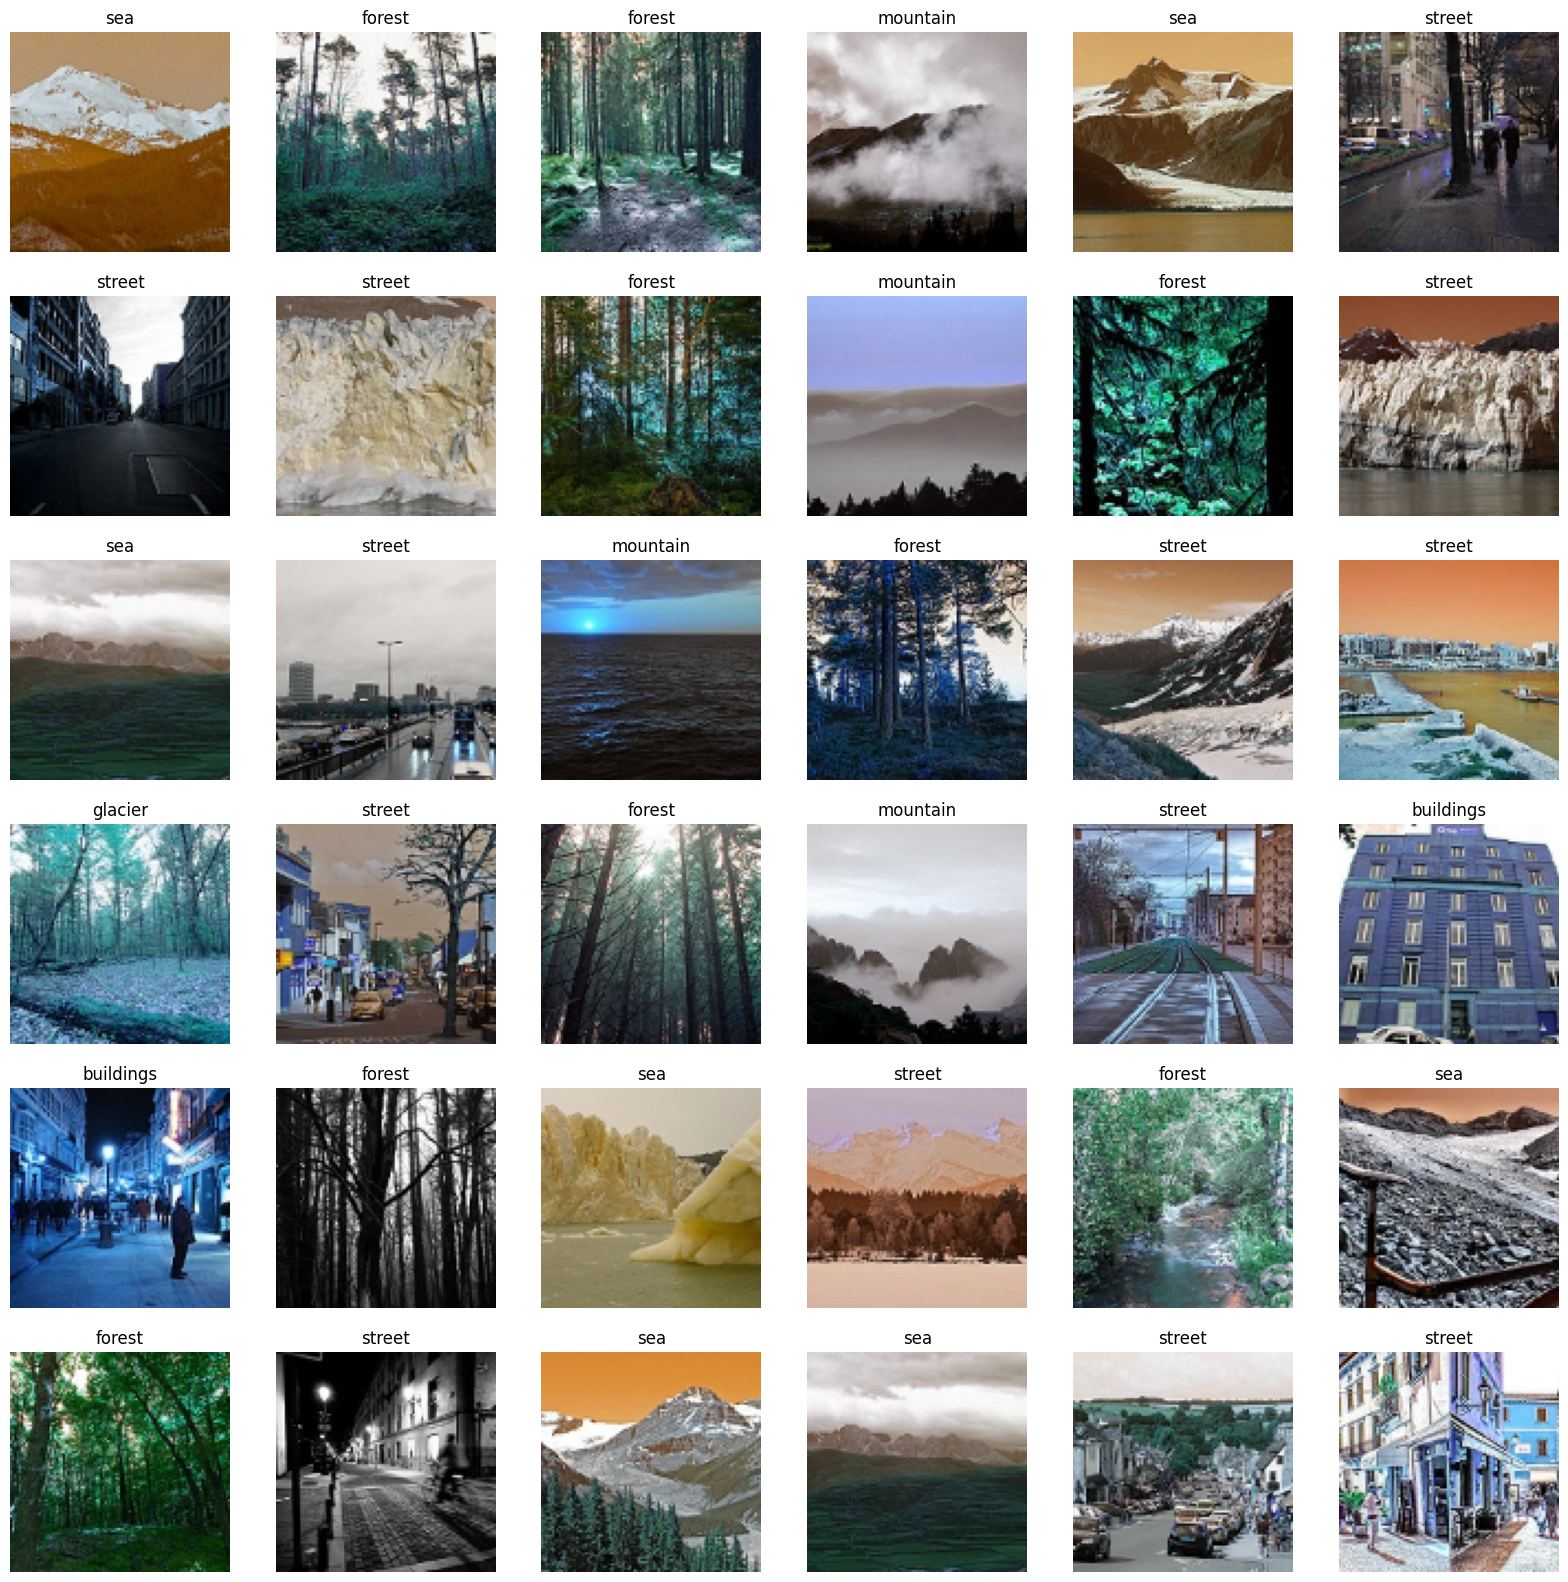

In [14]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(x_pred_norm),36))) :
    plt.subplot(6,6,n+1)
    plt.imshow(x_pred[i])
    plt.axis('off')
    plt.title(get_code(np.argmax(y_result[i])))

In [43]:
y_pred = KerasModel.predict(x_test_norm)   ## on x_test to commpare
y_pred_classes = np.argmax(y_pred, axis=1)

labels = list(code.values())
target_names = list(code.keys())

from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred_classes, labels=labels, target_names=target_names)

print(report)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_classes, labels=labels, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1_score:.4f}')


94/94 ━━━━━━━━━━━━━━━━━━━━ 25s 264ms/step
              precision    recall  f1-score   support

   buildings       0.84      0.61      0.71       437
      forest       0.91      0.97      0.94       474
     glacier       0.72      0.71      0.71       553
    mountain       0.67      0.74      0.70       525
         sea       0.77      0.66      0.71       510
      street       0.72      0.88      0.79       501

    accuracy                           0.76      3000
   macro avg       0.77      0.76      0.76      3000
weighted avg       0.77      0.76      0.76      3000

Precision: 0.7661
Recall: 0.7613
F1-score: 0.7588


#### Saving the results

In [45]:
KerasModel.save("D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/CNN_project.keras")

In [ ]:
KerasModel.save("D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/CNN_project.h5")

#### Loading the results

In [9]:
from tensorflow.keras.models import load_model
KerasModel = load_model("D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/CNN_project.keras")

c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 40 variables whereas the saved optimizer has 78 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [11]:
KerasModel.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_65 (Conv2D)              │ (None, 100, 100, 60)   │         1,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 100, 100, 60)   │        32,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 50, 50, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 50, 50, 120)    │        64,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 50, 50, 120)    │       129,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 25, 25, 120)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 25, 25, 240)    │       259,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 25, 25, 240)    │       518,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 25, 25, 240)    │       518,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 12, 12, 240)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 12, 12, 480)    │     1,037,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 12, 12, 480)    │     2,074,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 12, 12, 480)    │     2,074,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 6, 6, 480)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 6, 6, 600)      │     2,592,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 6, 6, 600)      │     3,240,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 6, 6, 600)      │     3,240,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 3, 3, 600)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 5400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 5400)           │        21,600 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │       691,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 128)            │           51

 Total params: 33,020,646 (125.96 MB)

 Trainable params: 16,504,666 (62.96 MB)

 Non-trainable params: 11,312 (44.19 KB)

 Optimizer params: 16,504,668 (62.96 MB)

In [10]:
x_test_norm = x_test/255    ## normalization
loss,accuracy=KerasModel.evaluate(x_test_norm,y_test)
print(f'loss is {loss}')
print(f'accuracy is {accuracy}')

79/79 ━━━━━━━━━━━━━━━━━━━━ 29s 359ms/step - accuracy: 0.7544 - loss: 0.6841
loss is 0.6599868535995483
accuracy is 0.7612000107765198


In [ ]:
## getting predicton score (confidence level)

y_result = KerasModel.predict(x_test_norm)
# print(y_result.shape)
Indices_y_result = np.argmax(y_result , axis=1)
# print(Indices_y_result.shape)
# print(Indices_y_result)

Score_y_result =[]
for i , index in enumerate(Indices_y_result):
    Score_y_result.append(y_result[i][index])

print(np.array(Score_y_result).shape)
print(f' The Predicton Score of 1st one is : {Score_y_result[0]*100:.2f}%')

79/79 ━━━━━━━━━━━━━━━━━━━━ 27s 333ms/step
(2500,)
 The Predicton Score of 1st one is : 99.76334571838379%


## ******Trial 2***

In [15]:
x_train , y_train = x_train_copy , y_train_copy
x_test, y_test = x_test_copy , y_test_copy
x_pred = x_pred_copy

x_train=np.array(x_train)[:10000]
x_test=np.array(x_test)[:2500]

y_train=np.array(y_train)[:10000]
y_test=np.array(y_test)[:2500]

x_pred=np.array(x_pred)[:500]

print(x_train.shape)
print(x_test.shape)

print(y_train.shape)
print(y_test.shape)

print(x_pred.shape)

# Create generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
      rescale=1.0/255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      brightness_range=(0.5,1.5),
      fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
      rescale=1.0/255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      brightness_range=(0.5,1.5),
      fill_mode='nearest'
)


train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=32
)

val_generator = val_datagen.flow(
    x_test,
    y_test,
    batch_size=32
)

print("\n" , "After Image Generator:")
print(x_train.shape)
print(x_test.shape)

print(y_train.shape)
print(y_test.shape)

(10000, 100, 100, 3)
(2500, 100, 100, 3)
(10000,)
(2500,)
(500, 100, 100, 3)

 After Image Generator:
(10000, 100, 100, 3)
(2500, 100, 100, 3)
(10000,)
(2500,)


In [9]:
### implement my model

T2_KerasModel = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(70, activation='relu', kernel_size=(5,5), padding='same',  input_shape=(100,100,3)),
    # tf.keras.layers.Conv2D(70, activation='relu', kernel_size=(3,3), padding='same', ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(150, activation='relu', kernel_size=(3,3), padding='same' ),
    tf.keras.layers.Conv2D(150, activation='relu', kernel_size=(3,3), padding='same' ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(300, activation='relu', kernel_size=(3,3), padding='same' ),
    tf.keras.layers.Conv2D(300, activation='relu', kernel_size=(3,3), padding='same' ),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Conv2D(300, activation='relu', kernel_size=(3,3), padding='same' ),
    tf.keras.layers.Conv2D(300, activation='relu', kernel_size=(3,3), padding='same' ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(600, activation='relu', kernel_size=(3,3), padding='same' ),
    tf.keras.layers.Conv2D(600, activation='relu', kernel_size=(3,3), padding='same' ),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Conv2D(600, activation='relu', kernel_size=(3,3), padding='same' ),
    tf.keras.layers.Conv2D(600, activation='relu', kernel_size=(3,3), padding='same' ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(600, activation='relu', kernel_size=(3,3), padding='same' ),
    tf.keras.layers.Conv2D(600, activation='relu', kernel_size=(3,3), padding='same' ),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Conv2D(600, activation='relu', kernel_size=(3,3), padding='same' ),
    tf.keras.layers.Conv2D(600, activation='relu', kernel_size=(3,3), padding='same' ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2, 2)),
    # tf.keras.layers.Conv2D(600, activation='relu', kernel_size=(3,3), padding='same' ),
    # tf.keras.layers.Conv2D(600, activation='relu', kernel_size=(3,3), padding='same' ),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Conv2D(600, activation='relu', kernel_size=(3,3), padding='same' ),
    # tf.keras.layers.Conv2D(600, activation='relu', kernel_size=(3,3), padding='same' ),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.MaxPool2D((2, 2)),

    tf.keras.layers.GlobalAveragePooling2D(),
    # tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(6, activation='softmax')
])

c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
T2_KerasModel.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [48]:
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping , LearningRateScheduler

# Define the path where you want to save the best model
model_save_path = 'D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/model_weights/T2_best_model.keras'  # Specify your desired path and filename

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    model_save_path,
    monitor='val_loss',  # Monitor validation loss; change to 'val_accuracy' if desired
    save_best_only=True,  # Save only the best model
    mode='min',  # 'min' for loss, 'max' for accuracy
    verbose=1  # Verbosity mode, 1 = save messages
)
'''''
## create EarlyStopping
earlystopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.04,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=4
)
'''''
'''''
## create LearningRateScheduler
def learnig_sheduler(epoch, lr):
    if epoch < 8:
        return lr 
    if epoch < 9:
        return lr * 0.1
    else:
        return lr 
lr_scheduler = LearningRateScheduler(learnig_sheduler)
'''''
    
# Train the model with the ModelCheckpoint callback
model = T2_KerasModel.fit(
    train_generator,
    validation_data=val_generator,  # Make sure to include validation data
    epochs=15,
    batch_size=64,
    verbose=1,
    callbacks=[checkpoint ]  # Pass the checkpoint callback here
)

Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3674 - loss: 1.7352
Epoch 1: val_loss improved from inf to 3.25143, saving model to D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/model_weights/T2_best_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 680s 2s/step - accuracy: 0.3675 - loss: 1.7346 - val_accuracy: 0.1676 - val_loss: 3.2514
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5094 - loss: 1.2784
Epoch 2: val_loss improved from 3.25143 to 1.37458, saving model to D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/model_weights/T2_best_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 682s 2s/step - accuracy: 0.5094 - loss: 1.2783 - val_accuracy: 0.4408 - val_loss: 1.3746
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5503 - loss: 1.1673
Epoch 3: val_loss improved from 1.37458 to 1.14801, saving model to D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/model_weights/T2_best_model.keras
313/313 ━━━━━━━

KeyboardInterrupt: 

In [13]:

## load model checkpoint
model_save_path = 'D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/model_weights/T2_best_model.keras'
T2_KerasModel = load_model(model_save_path)

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    model_save_path,
    monitor='val_loss',  # Monitor validation loss; change to 'val_accuracy' if desired
    save_best_only=True,  # Save only the best model
    mode='min',  # 'min' for loss, 'max' for accuracy
    verbose=1  # Verbosity mode, 1 = save messages
)

model = T2_KerasModel.fit(
    train_generator,
    validation_data=val_generator,  # Make sure to include validation data
    epochs=15,
    batch_size=64,
    verbose=1,
    callbacks=[checkpoint ]  # Pass the checkpoint callback here
)

Epoch 1/15


c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6665 - loss: 0.9106
Epoch 1: val_loss improved from inf to 1.28024, saving model to D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/model_weights/T2_best_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 538s 2s/step - accuracy: 0.6665 - loss: 0.9107 - val_accuracy: 0.5524 - val_loss: 1.2802
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6781 - loss: 0.8810
Epoch 2: val_loss improved from 1.28024 to 0.87825, saving model to D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/model_weights/T2_best_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 549s 2s/step - accuracy: 0.6781 - loss: 0.8809 - val_accuracy: 0.6768 - val_loss: 0.8782
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6885 - loss: 0.8534
Epoch 3: val_loss did not improve from 0.87825
313/313 ━━━━━━━━━━━━━━━━━━━━ 558s 2s/step - accuracy: 0.6885 - loss: 0.8534 - val_accuracy: 0.6496 - val_loss: 0.9959
Epoch 4/15
313/313 ━━━━━━━━

In [14]:
T2_KerasModel.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_600 (Conv2D)             │ (None, 100, 100, 70)   │         5,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_599         │ (None, 100, 100, 70)   │           280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 50, 50, 70)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_601 (Conv2D)             │ (None, 50, 50, 150)    │        94,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_602 (Conv2D)             │ (None, 50, 50, 150)    │       202,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_600         │ (None, 50, 50, 150)    │           600 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 25, 25, 150)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_603 (Conv2D)             │ (None, 25, 25, 300)    │       405,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_604 (Conv2D)             │ (None, 25, 25, 300)    │       810,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_605 (Conv2D)             │ (None, 25, 25, 300)    │       810,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_601         │ (None, 25, 25, 300)    │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 12, 12, 300)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_606 (Conv2D)             │ (None, 12, 12, 600)    │     1,620,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_607 (Conv2D)             │ (None, 12, 12, 600)    │     3,240,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_608 (Conv2D)             │ (None, 12, 12, 600)    │     3,240,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_602         │ (None, 12, 12, 600)    │         2,400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 6, 6, 600)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_609 (Conv2D)             │ (None, 6, 6, 600)      │     3,240,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_610 (Conv2D)             │ (None, 6, 6, 600)      │     3,240,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_611 (Conv2D)             │ (None, 6, 6, 600)      │     3,240,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_603         │ (None, 6, 6, 600)      │         2,400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 3, 3, 600)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 61,040,572 (232.85 MB)

 Trainable params: 20,345,054 (77.61 MB)

 Non-trainable params: 5,408 (21.12 KB)

 Optimizer params: 40,690,110 (155.22 MB)

In [15]:
x_test_norm = x_test/255    ## normalization
loss,accuracy=T2_KerasModel.evaluate(x_test_norm,y_test)

79/79 ━━━━━━━━━━━━━━━━━━━━ 43s 544ms/step - accuracy: 0.7398 - loss: 0.7583


In [16]:
print(f'loss is {loss}')
print(f'accuracy is {accuracy}')

loss is 0.754875898361206
accuracy is 0.7444000244140625


In [17]:
## saving model
T2_KerasModel.save("D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/T2_CNN_project.keras")
T2_KerasModel.save("D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/T2_CNN_project.h5")

## getting predicton score (confidence level)
x_test_norm = x_test/255    ## normalization
loss,accuracy=T2_KerasModel.evaluate(x_test_norm,y_test)
print(f'loss is {loss}')
print(f'accuracy is {accuracy}')
y_result = T2_KerasModel.predict(x_test_norm)
# print(y_result.shape)
Indices_y_result = np.argmax(y_result , axis=1)
# print(Indices_y_result.shape)
# print(Indices_y_result)

Score_y_result =[]
for i , index in enumerate(Indices_y_result):
    Score_y_result.append(y_result[i][index])

print(np.array(Score_y_result).shape)
print(f' The Predicton Score of 1st one is : {Score_y_result[0]*100:.2f}%')

79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 511ms/step - accuracy: 0.7398 - loss: 0.7583
loss is 0.754875898361206
accuracy is 0.7444000244140625
79/79 ━━━━━━━━━━━━━━━━━━━━ 30s 374ms/step
(2500,)
 The Predicton Score of 1st one is : 100.00%


## Trial 3 as DenseNet121_Like

In [43]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Dense, AveragePooling2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.layers import Concatenate, Add

def dense_block(x, num_layers, growth_rate):
    """Creates a dense block."""
    for _ in range(num_layers):
        # Batch Norm -> ReLU -> Conv (Bottleneck Layer)
        bn = BatchNormalization()(x)
        relu = Activation('relu')(bn)
        conv = Conv2D(4 * growth_rate, (1, 1), padding='same', use_bias=False)(relu)
        
        # Batch Norm -> ReLU -> Conv (3x3 Convolution)
        bn = BatchNormalization()(conv)
        relu = Activation('relu')(bn)
        conv = Conv2D(growth_rate, (3, 3), padding='same', use_bias=False)(relu)
        
        # Concatenate with the input tensor
        x = Concatenate()([x, conv])
    return x

def transition_layer(x, reduction):
    """Creates a transition layer."""
    # Batch Norm -> ReLU -> 1x1 Conv
    bn = BatchNormalization()(x)
    relu = Activation('relu')(bn)
    conv = Conv2D(int(tf.keras.backend.int_shape(x)[-1] * reduction), (1, 1), padding='same', use_bias=False)(relu)
    
    # Average Pooling
    x = AveragePooling2D((2, 2), strides=(2, 2))(conv)
    return x

def create_densenet121(input_shape=(100, 100, 3), num_classes=6):
    """Creates a DenseNet121-like model using tf.keras.Sequential."""
    inputs = Input(shape=input_shape)
    
    # Initial Convolution
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Dense Block 1
    x = dense_block(x, num_layers=6, growth_rate=32)
    x = transition_layer(x, reduction=0.5)
    
    # Dense Block 2
    x = dense_block(x, num_layers=12, growth_rate=32)
    x = transition_layer(x, reduction=0.5)
    
    # Dense Block 3
    x = dense_block(x, num_layers=24, growth_rate=32)
    x = transition_layer(x, reduction=0.5)
    
    # Dense Block 4
    x = dense_block(x, num_layers=16, growth_rate=32)
    
    # Global Average Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    
    # Fully Connected Layer
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Create Model
    model = tf.keras.Model(inputs, outputs, name="DenseNet121_Like")
    return model

# Instantiate the model
T3_KerasModel = create_densenet121(input_shape=(100, 100, 3), num_classes=6)

# Compile the model
T3_KerasModel.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
# T3_KerasModel.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])




In [ ]:
# Summary of the model
# T3_KerasModel.summary()

In [37]:
x_train , y_train = x_train_copy , y_train_copy
x_test, y_test = x_test_copy , y_test_copy
x_pred = x_pred_copy

x_train=np.array(x_train)[:10000]
x_test=np.array(x_test)[:2500]

y_train=np.array(y_train)[:10000]
y_test=np.array(y_test)[:2500]

x_pred=np.array(x_pred)[:500]

print(x_train.shape)
print(x_test.shape)

print(y_train.shape)
print(y_test.shape)

print(x_pred.shape)

# Create generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
      rescale=1.0/255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      brightness_range=(0.5,1.5),
      fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
      rescale=1.0/255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      brightness_range=(0.5,1.5),
      fill_mode='nearest'
)


train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=32
)

val_generator = val_datagen.flow(
    x_test,
    y_test,
    batch_size=32
)

print("\n" , "After Image Generator:")
print(x_train.shape)
print(x_test.shape)

print(y_train.shape)
print(y_test.shape)

(10000, 100, 100, 3)
(2500, 100, 100, 3)
(10000,)
(2500,)
(500, 100, 100, 3)

 After Image Generator:
(10000, 100, 100, 3)
(2500, 100, 100, 3)
(10000,)
(2500,)


In [44]:
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping , LearningRateScheduler

# Define the path where you want to save the best model
model_save_path = 'D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/model_weights/T3_best_model.keras'  # Specify your desired path and filename

# Create a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    model_save_path,
    monitor='val_loss',  # Monitor validation loss; change to 'val_accuracy' if desired
    save_best_only=True,  # Save only the best model
    mode='min',  # 'min' for loss, 'max' for accuracy
    verbose=1  # Verbosity mode, 1 = save messages
)
'''''
## create EarlyStopping
earlystopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.04,
    patience=3,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=4
)
'''''
'''''
## create LearningRateScheduler
def learnig_sheduler(epoch, lr):
    if epoch < 8:
        return lr 
    if epoch < 9:
        return lr * 0.1
    else:
        return lr 
lr_scheduler = LearningRateScheduler(learnig_sheduler)
'''''
    
# Train the model with the ModelCheckpoint callback
model = T3_KerasModel.fit(
    train_generator,
    validation_data=val_generator,  # Make sure to include validation data
    epochs=15,
    batch_size=64,
    verbose=1,
    callbacks=[checkpoint ]  # Pass the checkpoint callback here
)

Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 798ms/step - accuracy: 0.4150 - loss: 1.4437
Epoch 1: val_loss improved from inf to 2.91724, saving model to D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/model_weights/T3_best_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 362s 857ms/step - accuracy: 0.4151 - loss: 1.4433 - val_accuracy: 0.2684 - val_loss: 2.9172
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - accuracy: 0.5167 - loss: 1.1774
Epoch 2: val_loss did not improve from 2.91724
313/313 ━━━━━━━━━━━━━━━━━━━━ 244s 780ms/step - accuracy: 0.5168 - loss: 1.1774 - val_accuracy: 0.1904 - val_loss: 14.0926
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - accuracy: 0.5528 - loss: 1.1313
Epoch 3: val_loss improved from 2.91724 to 2.22236, saving model to D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/model_weights/T3_best_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 250s 798ms/step - accuracy: 0.5528 - loss: 1.1312 - val_accuracy: 0.2964 - val_loss: 2.22

In [45]:
## saving model
T3_KerasModel.save("D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/T3_CNN_project.keras")
T3_KerasModel.save("D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/T3_CNN_project.h5")

## getting predicton score (confidence level)
x_test_norm = x_test/255    ## normalization
loss,accuracy=T3_KerasModel.evaluate(x_test_norm,y_test)
print(f'loss is {loss}')
print(f'accuracy is {accuracy}')
y_result = T3_KerasModel.predict(x_test_norm)
# print(y_result.shape)
Indices_y_result = np.argmax(y_result , axis=1)
# print(Indices_y_result.shape)
# print(Indices_y_result)

Score_y_result =[]
for i , index in enumerate(Indices_y_result):
    Score_y_result.append(y_result[i][index])

print(np.array(Score_y_result).shape)
print(f' The Predicton Score of 1st one is : {Score_y_result[0]*100:.2f}%')

79/79 ━━━━━━━━━━━━━━━━━━━━ 16s 203ms/step - accuracy: 0.4694 - loss: 1.7525
loss is 1.7506498098373413
accuracy is 0.4708000123500824
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 220ms/step
(2500,)
 The Predicton Score of 1st one is : 78.94%


## Pre Trained Models

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report

## retain original data after shuffle
x_train , y_train = x_train_copy , y_train_copy
x_test, y_test = x_test_copy , y_test_copy
x_pred = x_pred_copy

num_classes = 6
xx_train = np.array(x_train)[:8000]
xx_test = np.array(x_test)[:2000]
yy_train = to_categorical(np.array(y_train)[:8000], num_classes=num_classes)
yy_test = to_categorical(np.array(y_test)[:2000], num_classes=num_classes)
print(xx_train.shape)
print(xx_test.shape)

print(yy_train.shape)
print(yy_test.shape)

train_datagen = ImageDataGenerator(
      rescale=1.0/255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      brightness_range=(0.5,1.5),
      fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
      rescale=1.0/255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      brightness_range=(0.5,1.5),
      fill_mode='nearest'
)


# Create generators
train_generator = train_datagen.flow(
    xx_train,
    yy_train,
    batch_size=32
)

val_generator = val_datagen.flow(
    xx_test,
    yy_test,
    batch_size=32
)

print("\n" , "After Image Generator:")
print(xx_train.shape)
print(xx_test.shape)

print(yy_train.shape)
print(yy_test.shape)



(8000, 100, 100, 3)
(2000, 100, 100, 3)
(8000, 6)
(2000, 6)

 After Image Generator:
(8000, 100, 100, 3)
(2000, 100, 100, 3)
(8000, 6)
(2000, 6)


In [26]:
def vgg16_architecture():
    base_model = VGG16(include_top=False, weights="imagenet", input_shape=(100, 100, 3))
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    # # x = Dropout(0.80)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    # # x = Dropout(0.80)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    # # x = Dropout(0.80)(x)



    output = Dense(num_classes, activation='softmax')(x)

    VGG16_model = Model(inputs=base_model.input, outputs=output)

    VGG16_model.summary()

    optimizer = Adam(learning_rate=0.001)
    VGG16_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return VGG16_model

In [27]:
def vgg19_architecture():
    from keras.applications import VGG19
    from keras.layers import BatchNormalization, Dropout

    base_model = VGG19(include_top=False, weights="imagenet", input_shape=(100, 100, 3))
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    # x = Dropout(0.80)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    # # x = Dropout(0.80)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    # # x = Dropout(0.80)(x)

    output = Dense(6, activation='softmax')(x)

    VGG19_model = Model(inputs=base_model.input, outputs=output)

    VGG19_model.summary()

    optimizer = Adam(learning_rate=0.001)
    VGG19_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return VGG19_model

In [28]:
def resnet152v2_architecture():
    from keras.applications import ResNet152V2
    from keras.layers import BatchNormalization, Dropout

    base_model = ResNet152V2(include_top=False, weights="imagenet", input_shape=(100, 100, 3))
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    # # x = Dropout(0.80)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    # x = Dropout(0.50)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    # x = Dropout(0.50)(x)

    output = Dense(6, activation='softmax')(x)

    ResNet152V2_model = Model(inputs=base_model.input, outputs=output)

    ResNet152V2_model.summary()

    optimizer = Adam(learning_rate=0.001)
    ResNet152V2_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return ResNet152V2_model

In [29]:
def inception_v3_architecture():
    from keras.applications import InceptionV3

    from keras.layers import BatchNormalization, Dropout

    base_model = InceptionV3(include_top=False, weights="imagenet", input_shape=(100, 100, 3))
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # x = BatchNormalization()(x)
    # x = Dropout(0.80)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    # x = Dropout(0.50)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    # x = Dropout(0.50)(x)

    output = Dense(6, activation='softmax')(x)

    InceptionV3_model = Model(inputs=base_model.input, outputs=output)

    InceptionV3_model.summary()

    optimizer = Adam(learning_rate=0.001)
    InceptionV3_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return InceptionV3_model

In [30]:
def DenseNet121_architecture():
    from keras.applications import DenseNet121
    from keras.layers import BatchNormalization, Dropout

    base_model = DenseNet121(include_top=False, weights="imagenet", input_shape=(100, 100, 3))
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    # # x = Dropout(0.80)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    # # x = Dropout(0.80)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    # # x = Dropout(0.80)(x)

    output = Dense(6, activation='softmax')(x)

    DenseNet121_model = Model(inputs=base_model.input, outputs=output)

    DenseNet121_model.summary()

    optimizer = Adam(learning_rate=0.001)

    DenseNet121_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return DenseNet121_model

In [31]:
def evaluate_model(model, x_test, y_test):
    x_test = x_test / 255  ## normalize
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f"Loss: {loss}")
    print(f"Accuracy: {accuracy}")
    return loss, accuracy

    # cm = confusion_matrix(y_true, y_pred)
    # print("Confusion Matrix:")
    # print(cm)

    # cr = classification_report(y_true, y_pred, target_names=[f'class_{i}' for i in range(3)])
    # print("Classification Report:")
    # print(cr)

    # return cm, cr




In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

def generate_confusion_matrix_and_metrics(model, x_test, y_test):
    # Generate predictions
    x_test = x_test / 255  ## normalize
    y_pred = model.predict(x_test)

    # Check the shape of y_pred and y_test
    print(f"y_pred shape: {y_pred.shape}")
    print(f"y_test shape: {y_test.shape}")

    # Handle binary and multi-class predictions
    if len(y_pred.shape) == 1:  # Binary classification
        y_pred_classes = (y_pred > 0.5).astype(int)
    else:  # Multi-class classification
        y_pred_classes = np.argmax(y_pred, axis=1)

    # Check the shape after prediction conversion
    print(f"y_pred_classes shape: {y_pred_classes.shape}")

    # Check true labels
    if len(y_test.shape) == 1:  # if y_test is one-dimensional
        y_true = y_test.astype(int)  # assuming y_test contains class indices directly
    else:
        y_true = np.argmax(y_test, axis=1)  # True classes in one-hot encoded format

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # Plot the confusion matrix
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Classification report
    labels = np.unique(y_true)
    target_names = [f'class_{label}' for label in labels]
    report = classification_report(y_true, y_pred_classes, labels=labels, target_names=target_names)
    print("Classification Report:")
    print(report)

    # Precision, Recall, F1-score
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, labels=labels, average='weighted')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1_score:.4f}')

    return cm, report, precision, recall, f1_score


Training VGG16...


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_15     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_308         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,719,814 (56.15 MB)

 Trainable params: 4,102 (16.02 KB)

 Non-trainable params: 14,715,712 (56.14 MB)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 412ms/step - accuracy: 0.3564 - loss: 1.6819 - val_accuracy: 0.5060 - val_loss: 1.3974
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 396ms/step - accuracy: 0.6271 - loss: 1.0073 - val_accuracy: 0.6160 - val_loss: 1.2035
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 386ms/step - accuracy: 0.6529 - loss: 0.9317 - val_accuracy: 0.6240 - val_loss: 1.0629
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 390ms/step - accuracy: 0.6746 - loss: 0.8565 - val_accuracy: 0.6660 - val_loss: 0.9630
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 391ms/step - accuracy: 0.6688 - loss: 0.8420 - val_accuracy: 0.6760 - val_loss: 0.8951
Evaluating VGG16...
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 296ms/step - accuracy: 0.7224 - loss: 0.7271
Loss: 0.7482152581214905
Accuracy: 0.7179999947547913
VGG16 evaluation complete.
Accuracy: 0.7179999947547913

_____ _____ _____
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 301ms/step
y_pred shape: (500, 6)
y_test shape: (500, 6)
y_pred_classes shape: (500,)


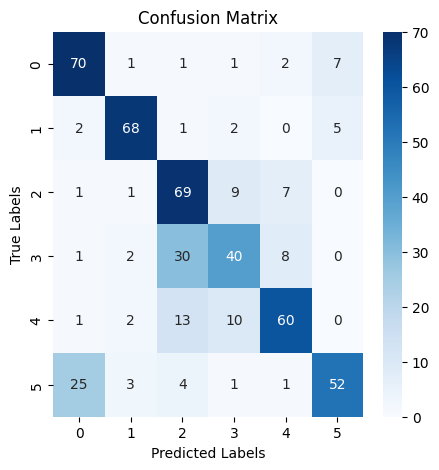

Classification Report:
              precision    recall  f1-score   support

     class_0       0.70      0.85      0.77        82
     class_1       0.88      0.87      0.88        78
     class_2       0.58      0.79      0.67        87
     class_3       0.63      0.49      0.56        81
     class_4       0.77      0.70      0.73        86
     class_5       0.81      0.60      0.69        86

    accuracy                           0.72       500
   macro avg       0.73      0.72      0.72       500
weighted avg       0.73      0.72      0.72       500

Precision: 0.7292
Recall: 0.7180
F1-score: 0.7153
_______________________________________________________________________
Training VGG19...


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_309         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 20,029,510 (76.41 MB)

 Trainable params: 4,102 (16.02 KB)

 Non-trainable params: 20,025,408 (76.39 MB)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 505ms/step - accuracy: 0.3984 - loss: 1.6040 - val_accuracy: 0.3720 - val_loss: 1.6626
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 498ms/step - accuracy: 0.5854 - loss: 1.0702 - val_accuracy: 0.4600 - val_loss: 1.3932
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 513ms/step - accuracy: 0.6215 - loss: 0.9612 - val_accuracy: 0.5400 - val_loss: 1.1750
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 507ms/step - accuracy: 0.6608 - loss: 0.8860 - val_accuracy: 0.6180 - val_loss: 1.0223
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 516ms/step - accuracy: 0.6974 - loss: 0.8497 - val_accuracy: 0.6320 - val_loss: 0.9487
Evaluating VGG19...
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 387ms/step - accuracy: 0.7219 - loss: 0.7873
Loss: 0.7901588678359985
Accuracy: 0.7239999771118164
VGG19 evaluation complete.
Accuracy: 0.7239999771118164

_____ _____ _____
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 390ms/step
y_pred shape: (500, 6)
y_test shape: (500, 6)
y_pred_classes shape: (500,)


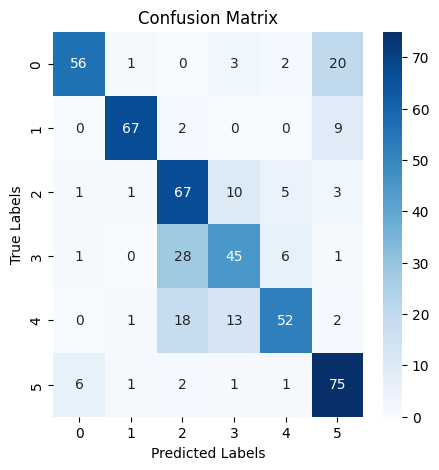

Classification Report:
              precision    recall  f1-score   support

     class_0       0.88      0.68      0.77        82
     class_1       0.94      0.86      0.90        78
     class_2       0.57      0.77      0.66        87
     class_3       0.62      0.56      0.59        81
     class_4       0.79      0.60      0.68        86
     class_5       0.68      0.87      0.77        86

    accuracy                           0.72       500
   macro avg       0.75      0.72      0.73       500
weighted avg       0.74      0.72      0.73       500

Precision: 0.7444
Recall: 0.7240
F1-score: 0.7250
_______________________________________________________________________
Training ResNet152V2...


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 106, 106,  │          0 │ input_layer_17[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 50, 50,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 52, 52,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 25, 25,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 25, 25,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 25, 25,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 25, 25,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 25, 25,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 25, 25,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 27, 27,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 25, 25,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 25, 25,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 25, 25,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 25, 25,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 25, 25,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 25, 25,    │          0 │ conv2_block1_0_c

 Total params: 58,352,134 (222.60 MB)

 Trainable params: 16,390 (64.02 KB)

 Non-trainable params: 58,335,744 (222.53 MB)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 55s 681ms/step - accuracy: 0.4101 - loss: 1.6142 - val_accuracy: 0.6340 - val_loss: 1.0232
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 608ms/step - accuracy: 0.6612 - loss: 0.9018 - val_accuracy: 0.7080 - val_loss: 0.9022
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 614ms/step - accuracy: 0.7075 - loss: 0.7978 - val_accuracy: 0.6820 - val_loss: 0.8173
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 615ms/step - accuracy: 0.7031 - loss: 0.8046 - val_accuracy: 0.7120 - val_loss: 0.8338
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 39s 616ms/step - accuracy: 0.7385 - loss: 0.7247 - val_accuracy: 0.7100 - val_loss: 0.7844
Evaluating ResNet152V2...
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 469ms/step - accuracy: 0.7589 - loss: 0.6389
Loss: 0.6143072247505188
Accuracy: 0.7720000147819519
ResNet152V2 evaluation complete.
Accuracy: 0.7720000147819519

_____ _____ _____
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 684ms/step
y_pred shape: (500, 6)
y_test shape: (500, 6)
y_pred_classes shape: (500,)


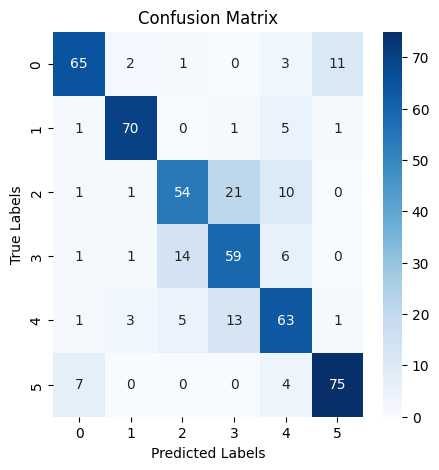

Classification Report:
              precision    recall  f1-score   support

     class_0       0.86      0.79      0.82        82
     class_1       0.91      0.90      0.90        78
     class_2       0.73      0.62      0.67        87
     class_3       0.63      0.73      0.67        81
     class_4       0.69      0.73      0.71        86
     class_5       0.85      0.87      0.86        86

    accuracy                           0.77       500
   macro avg       0.78      0.77      0.77       500
weighted avg       0.78      0.77      0.77       500

Precision: 0.7764
Recall: 0.7720
F1-score: 0.7725
_______________________________________________________________________
Training InceptionV3...


Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_282 (Conv2D) │ (None, 49, 49,    │        864 │ input_layer_18[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 49,    │         96 │ conv2d_282[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_282      │ (None, 49, 49,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_283 (Conv2D) │ (None, 47, 47,    │      9,216 │ activation_282[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 47, 47,    │         96 │ conv2d_283[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_283      │ (None, 47, 47,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_284 (Conv2D) │ (None, 47, 47,    │     18,432 │ activation_283[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 47, 47,    │        192 │ conv2d_284[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_284      │ (None, 47, 47,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 23, 23,    │          0 │ activation_284[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_285 (Conv2D) │ (None, 23, 23,    │      5,120 │ max_pooling2d_24… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 23, 23,    │        240 │ conv2d_285[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_285      │ (None, 23, 23,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_286 (Conv2D) │ (None, 21, 21,    │    138,240 │ activation_285[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 21, 21,    │        576 │ conv2d_286[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_286      │ (None, 21, 21,    │          0 │ batch_normalizat

 Total params: 22,362,534 (85.31 MB)

 Trainable params: 558,982 (2.13 MB)

 Non-trainable params: 21,803,552 (83.17 MB)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - accuracy: 0.2655 - loss: 2.3374 - val_accuracy: 0.5160 - val_loss: 1.2757
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.4416 - loss: 1.6478 - val_accuracy: 0.5960 - val_loss: 1.1474
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.5298 - loss: 1.3592 - val_accuracy: 0.5980 - val_loss: 1.0829
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.5294 - loss: 1.2753 - val_accuracy: 0.6500 - val_loss: 0.9169
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.5509 - loss: 1.2087 - val_accuracy: 0.6240 - val_loss: 0.9971
Evaluating InceptionV3...
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.6774 - loss: 0.8768
Loss: 0.9183954000473022
Accuracy: 0.6359999775886536
InceptionV3 evaluation complete.
Accuracy: 0.6359999775886536

_____ _____ _____
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step
y_pred shape: (500, 6)
y_test shape: (500, 6)
y_pred_classes shape: (500,)


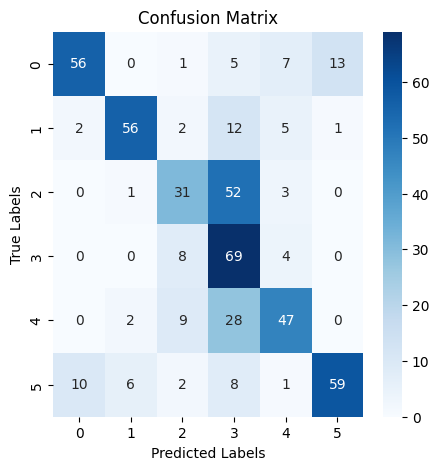

Classification Report:
              precision    recall  f1-score   support

     class_0       0.82      0.68      0.75        82
     class_1       0.86      0.72      0.78        78
     class_2       0.58      0.36      0.44        87
     class_3       0.40      0.85      0.54        81
     class_4       0.70      0.55      0.61        86
     class_5       0.81      0.69      0.74        86

    accuracy                           0.64       500
   macro avg       0.70      0.64      0.65       500
weighted avg       0.70      0.64      0.64       500

Precision: 0.6951
Recall: 0.6360
F1-score: 0.6427
_______________________________________________________________________
Training DenseNet121...


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_6    │ (None, 106, 106,  │          0 │ input_layer_19[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 50, 50,    │      9,408 │ zero_padding2d_6… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 50, 50,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 50, 50,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_7    │ (None, 52, 52,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 25, 25,    │          0 │ zero_padding2d_7… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 25, 25,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 25, 25,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 25, 25,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 25, 25,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 25, 25,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 25, 25,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 25, 25,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 25, 25,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 25, 25,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 25, 25,    │     12,288 │ conv2_block2_0_r

 Total params: 7,047,750 (26.89 MB)

 Trainable params: 8,198 (32.02 KB)

 Non-trainable params: 7,039,552 (26.85 MB)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 204ms/step - accuracy: 0.4361 - loss: 1.5163 - val_accuracy: 0.6500 - val_loss: 0.9632
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - accuracy: 0.7170 - loss: 0.7512 - val_accuracy: 0.6960 - val_loss: 0.7701
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 0.7676 - loss: 0.6377 - val_accuracy: 0.7360 - val_loss: 0.7367
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.7674 - loss: 0.6400 - val_accuracy: 0.7320 - val_loss: 0.7238
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.7698 - loss: 0.6179 - val_accuracy: 0.7500 - val_loss: 0.6825
Evaluating DenseNet121...
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.7909 - loss: 0.5267
Loss: 0.521085798740387
Accuracy: 0.800000011920929
DenseNet121 evaluation complete.
Accuracy: 0.800000011920929

_____ _____ _____
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 278ms/step
y_pred shape: (500, 6)
y_test shape: (500, 6)
y_pred_classes shape: (500,)


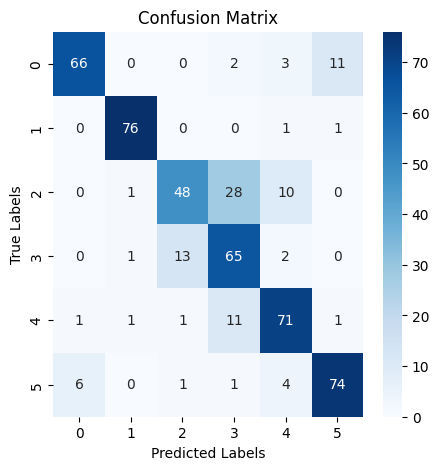

Classification Report:
              precision    recall  f1-score   support

     class_0       0.90      0.80      0.85        82
     class_1       0.96      0.97      0.97        78
     class_2       0.76      0.55      0.64        87
     class_3       0.61      0.80      0.69        81
     class_4       0.78      0.83      0.80        86
     class_5       0.85      0.86      0.86        86

    accuracy                           0.80       500
   macro avg       0.81      0.80      0.80       500
weighted avg       0.81      0.80      0.80       500

Precision: 0.8098
Recall: 0.8000
F1-score: 0.7992
_______________________________________________________________________


In [46]:
### get evalation and confusion matrix with no dense functions :
''''
models = {
     "VGG16": vgg16_architecture,
     "VGG19": vgg19_architecture,
     "ResNet152V2": resnet152v2_architecture,
     "InceptionV3": inception_v3_architecture,
     "DenseNet121": DenseNet121_architecture
}

for model_name, model_func in models.items():
    print(f"Training {model_name}...")
    model = model_func()
    model.fit(
        train_generator,
        validation_data=val_generator,
        epochs = 5  # Adjust epochs as needed
    )
    print(f"Evaluating {model_name}...")
    loss, accuracy = evaluate_model(model, xx_test, yy_test)
    print(f"{model_name} evaluation complete.")
    print(f"Accuracy: {accuracy}\n")
    print("_____ _____ _____")
    generate_confusion_matrix_and_metrics(model, xx_test, yy_test)
    print("_______________________________________________________________________")
''''

Training VGG16...


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_20     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_420         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_421         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 14,883,270 (56.78 MB)

 Trainable params: 166,790 (651.52 KB)

 Non-trainable params: 14,716,480 (56.14 MB)

Epoch 1/6


c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 410ms/step - accuracy: 0.4962 - loss: 1.3493 - val_accuracy: 0.5250 - val_loss: 1.2693
Epoch 2/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 38s 409ms/step - accuracy: 0.6886 - loss: 0.7931 - val_accuracy: 0.6150 - val_loss: 1.0332
Epoch 3/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 37s 397ms/step - accuracy: 0.6990 - loss: 0.7858 - val_accuracy: 0.6725 - val_loss: 0.8481
Epoch 4/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 38s 403ms/step - accuracy: 0.7286 - loss: 0.7144 - val_accuracy: 0.6975 - val_loss: 0.7868
Epoch 5/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 39s 412ms/step - accuracy: 0.7440 - loss: 0.7153 - val_accuracy: 0.7000 - val_loss: 0.7631
Epoch 6/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 38s 407ms/step - accuracy: 0.7479 - loss: 0.6614 - val_accuracy: 0.7088 - val_loss: 0.7703
Evaluating VGG16...
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 306ms/step - accuracy: 0.7894 - loss: 0.5602
Loss: 0.5890131592750549
Accuracy: 0.7649999856948853
VGG16 evaluation complete.
Accuracy: 0.7649999856948853

_____ _____ _____
25/25 ━━━━━━━━━━━━

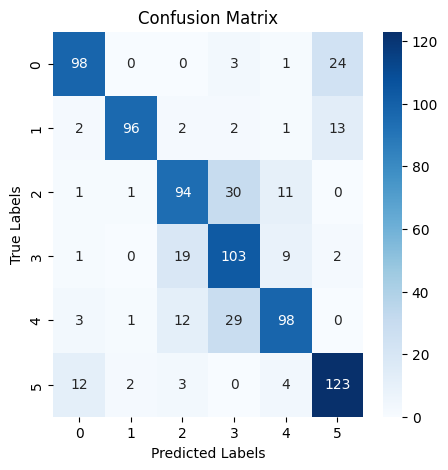

Classification Report:
              precision    recall  f1-score   support

     class_0       0.84      0.78      0.81       126
     class_1       0.96      0.83      0.89       116
     class_2       0.72      0.69      0.70       137
     class_3       0.62      0.77      0.68       134
     class_4       0.79      0.69      0.73       143
     class_5       0.76      0.85      0.80       144

    accuracy                           0.77       800
   macro avg       0.78      0.77      0.77       800
weighted avg       0.78      0.77      0.77       800

Precision: 0.7762
Recall: 0.7650
F1-score: 0.7671
_______________________________________________________________________
Training VGG19...


Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)     │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_21     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_423         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 20,192,966 (77.03 MB)

 Trainable params: 166,790 (651.52 KB)

 Non-trainable params: 20,026,176 (76.39 MB)

Epoch 1/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 50s 512ms/step - accuracy: 0.5108 - loss: 1.3470 - val_accuracy: 0.4888 - val_loss: 1.3210
Epoch 2/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 49s 523ms/step - accuracy: 0.6552 - loss: 0.9215 - val_accuracy: 0.6488 - val_loss: 0.9765
Epoch 3/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 49s 525ms/step - accuracy: 0.7042 - loss: 0.8017 - val_accuracy: 0.6775 - val_loss: 0.8702
Epoch 4/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 49s 524ms/step - accuracy: 0.6896 - loss: 0.8051 - val_accuracy: 0.6875 - val_loss: 0.8199
Epoch 5/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 49s 524ms/step - accuracy: 0.7089 - loss: 0.7499 - val_accuracy: 0.6950 - val_loss: 0.8244
Epoch 6/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 49s 525ms/step - accuracy: 0.7162 - loss: 0.7654 - val_accuracy: 0.6787 - val_loss: 0.7852
Evaluating VGG19...
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 400ms/step - accuracy: 0.7792 - loss: 0.5927
Loss: 0.639838695526123
Accuracy: 0.75
VGG19 evaluation complete.
Accuracy: 0.75

_____ _____ _____
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 400ms

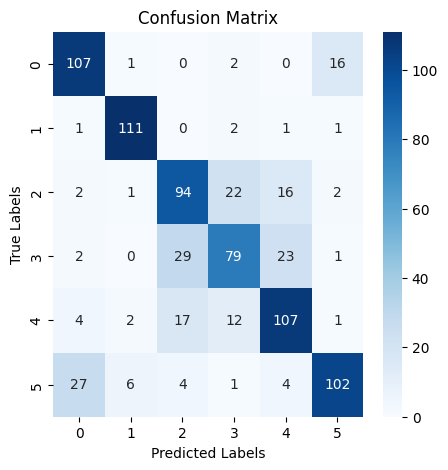

Classification Report:
              precision    recall  f1-score   support

     class_0       0.75      0.85      0.80       126
     class_1       0.92      0.96      0.94       116
     class_2       0.65      0.69      0.67       137
     class_3       0.67      0.59      0.63       134
     class_4       0.71      0.75      0.73       143
     class_5       0.83      0.71      0.76       144

    accuracy                           0.75       800
   macro avg       0.75      0.76      0.75       800
weighted avg       0.75      0.75      0.75       800

Precision: 0.7507
Recall: 0.7500
F1-score: 0.7484
_______________________________________________________________________
Training ResNet152V2...


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 106, 106,  │          0 │ input_layer_25[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 50, 50,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 52, 52,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 25, 25,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 25, 25,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 25, 25,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 25, 25,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 25, 25,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 25, 25,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 27, 27,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 25, 25,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 25, 25,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 25, 25,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 25, 25,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 25, 25,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 25, 25,    │          0 │ conv2_block1_0_c

 Total params: 58,899,590 (224.68 MB)

 Trainable params: 563,078 (2.15 MB)

 Non-trainable params: 58,336,512 (222.54 MB)

Epoch 1/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 74s 646ms/step - accuracy: 0.5395 - loss: 1.3012 - val_accuracy: 0.6762 - val_loss: 0.8980
Epoch 2/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 609ms/step - accuracy: 0.7058 - loss: 0.7914 - val_accuracy: 0.7063 - val_loss: 0.7827
Epoch 3/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 610ms/step - accuracy: 0.7300 - loss: 0.7149 - val_accuracy: 0.7487 - val_loss: 0.7113
Epoch 4/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 610ms/step - accuracy: 0.7549 - loss: 0.6706 - val_accuracy: 0.7212 - val_loss: 0.7537
Epoch 5/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 611ms/step - accuracy: 0.7366 - loss: 0.6672 - val_accuracy: 0.7175 - val_loss: 0.7439
Epoch 6/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 609ms/step - accuracy: 0.7605 - loss: 0.6250 - val_accuracy: 0.7425 - val_loss: 0.7048
Evaluating ResNet152V2...
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 466ms/step - accuracy: 0.8200 - loss: 0.5402
Loss: 0.5048988461494446
Accuracy: 0.8149999976158142
ResNet152V2 evaluation complete.
Accuracy: 0.8149999976158142

_____ _____ _

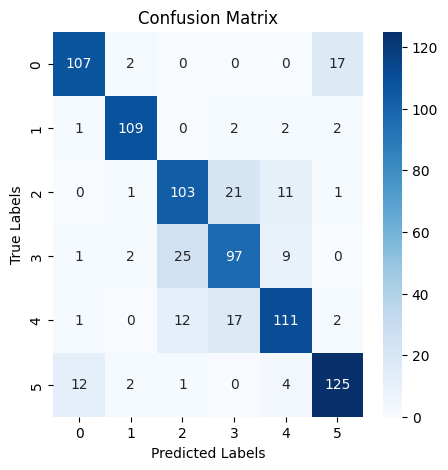

Classification Report:
              precision    recall  f1-score   support

     class_0       0.88      0.85      0.86       126
     class_1       0.94      0.94      0.94       116
     class_2       0.73      0.75      0.74       137
     class_3       0.71      0.72      0.72       134
     class_4       0.81      0.78      0.79       143
     class_5       0.85      0.87      0.86       144

    accuracy                           0.81       800
   macro avg       0.82      0.82      0.82       800
weighted avg       0.82      0.81      0.82       800

Precision: 0.8160
Recall: 0.8150
F1-score: 0.8153
_______________________________________________________________________
Training InceptionV3...


Model: "functional_26"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_415 (Conv2D) │ (None, 49, 49,    │        864 │ input_layer_26[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 49,    │         96 │ conv2d_415[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_376      │ (None, 49, 49,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_416 (Conv2D) │ (None, 47, 47,    │      9,216 │ activation_376[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 47, 47,    │         96 │ conv2d_416[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_377      │ (None, 47, 47,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_417 (Conv2D) │ (None, 47, 47,    │     18,432 │ activation_377[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 47, 47,    │        192 │ conv2d_417[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_378      │ (None, 47, 47,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_46    │ (None, 23, 23,    │          0 │ activation_378[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_418 (Conv2D) │ (None, 23, 23,    │      5,120 │ max_pooling2d_46… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 23, 23,    │        240 │ conv2d_418[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_379      │ (None, 23, 23,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_419 (Conv2D) │ (None, 21, 21,    │    138,240 │ activation_379[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 21, 21,    │        576 │ conv2d_419[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_380      │ (None, 21, 21,    │          0 │ batch_normalizat

 Total params: 22,362,534 (85.31 MB)

 Trainable params: 558,982 (2.13 MB)

 Non-trainable params: 21,803,552 (83.17 MB)

Epoch 1/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - accuracy: 0.4415 - loss: 1.5482 - val_accuracy: 0.5700 - val_loss: 1.1693
Epoch 2/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.6213 - loss: 1.0365 - val_accuracy: 0.6338 - val_loss: 0.9793
Epoch 3/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.6126 - loss: 0.9705 - val_accuracy: 0.6338 - val_loss: 1.0241
Epoch 4/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - accuracy: 0.6463 - loss: 0.9541 - val_accuracy: 0.6300 - val_loss: 0.9708
Epoch 5/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.6473 - loss: 0.8866 - val_accuracy: 0.6212 - val_loss: 0.9479
Epoch 6/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.6531 - loss: 0.8745 - val_accuracy: 0.6750 - val_loss: 0.9244
Evaluating InceptionV3...
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.6977 - loss: 0.7567
Loss: 0.806704580783844
Accuracy: 0.6812499761581421
InceptionV3 evaluation complete.
Accuracy: 0.6812499761581421

_____ _____ ____

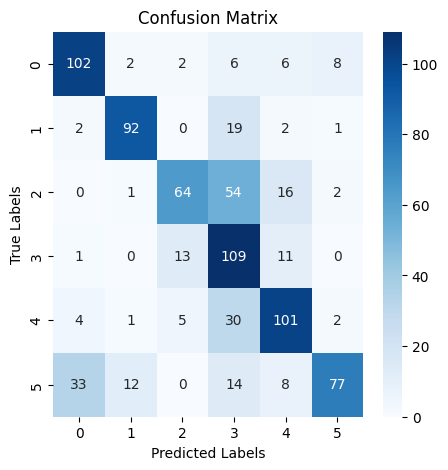

Classification Report:
              precision    recall  f1-score   support

     class_0       0.72      0.81      0.76       126
     class_1       0.85      0.79      0.82       116
     class_2       0.76      0.47      0.58       137
     class_3       0.47      0.81      0.60       134
     class_4       0.70      0.71      0.70       143
     class_5       0.86      0.53      0.66       144

    accuracy                           0.68       800
   macro avg       0.73      0.69      0.69       800
weighted avg       0.73      0.68      0.68       800

Precision: 0.7252
Recall: 0.6813
F1-score: 0.6822
_______________________________________________________________________
Training DenseNet121...


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_8    │ (None, 106, 106,  │          0 │ input_layer_27[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 50, 50,    │      9,408 │ zero_padding2d_8… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 50, 50,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 50, 50,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_9    │ (None, 52, 52,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 25, 25,    │          0 │ zero_padding2d_9… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 25, 25,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 25, 25,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 25, 25,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 25, 25,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 25, 25,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 25, 25,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 25, 25,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 25, 25,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 25, 25,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 25, 25,    │     12,288 │ conv2_block2_0_r

 Total params: 7,339,206 (28.00 MB)

 Trainable params: 298,886 (1.14 MB)

 Non-trainable params: 7,040,320 (26.86 MB)

Epoch 1/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 32s 234ms/step - accuracy: 0.5944 - loss: 1.1157 - val_accuracy: 0.6938 - val_loss: 0.8312
Epoch 2/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 199ms/step - accuracy: 0.7591 - loss: 0.6443 - val_accuracy: 0.7575 - val_loss: 0.6603
Epoch 3/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 199ms/step - accuracy: 0.7930 - loss: 0.5744 - val_accuracy: 0.7825 - val_loss: 0.5849
Epoch 4/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 196ms/step - accuracy: 0.8144 - loss: 0.5025 - val_accuracy: 0.7875 - val_loss: 0.5470
Epoch 5/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 196ms/step - accuracy: 0.8003 - loss: 0.5402 - val_accuracy: 0.8075 - val_loss: 0.5523
Epoch 6/6
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 196ms/step - accuracy: 0.8244 - loss: 0.4599 - val_accuracy: 0.7850 - val_loss: 0.5718
Evaluating DenseNet121...
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 0.8028 - loss: 0.4514
Loss: 0.4290340840816498
Accuracy: 0.8212500214576721
DenseNet121 evaluation complete.
Accuracy: 0.8212500214576721

_____ _____ __

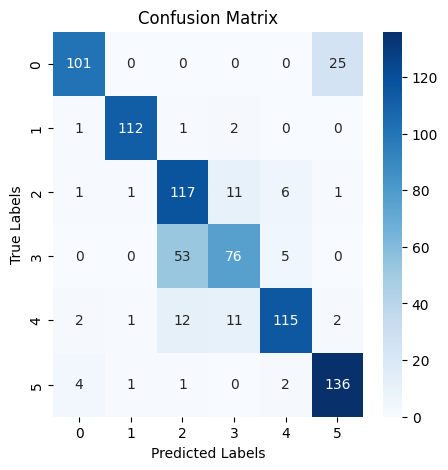

Classification Report:
              precision    recall  f1-score   support

     class_0       0.93      0.80      0.86       126
     class_1       0.97      0.97      0.97       116
     class_2       0.64      0.85      0.73       137
     class_3       0.76      0.57      0.65       134
     class_4       0.90      0.80      0.85       143
     class_5       0.83      0.94      0.88       144

    accuracy                           0.82       800
   macro avg       0.84      0.82      0.82       800
weighted avg       0.83      0.82      0.82       800

Precision: 0.8332
Recall: 0.8213
F1-score: 0.8203
_______________________________________________________________________


In [87]:

### get evaluation and confusion matrix with dense layers
''''
models = {
     "VGG16": vgg16_architecture,
     "VGG19": vgg19_architecture,
     "ResNet152V2": resnet152v2_architecture,
     "InceptionV3": inception_v3_architecture,
     "DenseNet121": DenseNet121_architecture
}

for model_name, model_func in models.items():
    print(f"Training {model_name}...")
    model = model_func()
    model.fit(
        train_generator,
        validation_data=val_generator,
        epochs = 6  # Adjust epochs as needed
    )
    print(f"Evaluating {model_name}...")
    loss, accuracy = evaluate_model(model, xx_test, yy_test)
    print(f"{model_name} evaluation complete.")
    print(f"Accuracy: {accuracy}\n")
    print("_____ _____ _____")
    generate_confusion_matrix_and_metrics(model, xx_test, yy_test)
    print("_______________________________________________________________________")

''''


In [1]:
## get last model confusion matrix
generate_confusion_matrix_and_metrics(model, xx_test, yy_test)

NameError: name 'generate_confusion_matrix_and_metrics' is not defined

In [27]:
print(model_name)

DenseNet121


## PRE TRAINED SAVING

Training VGG16...


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 14,883,270 (56.78 MB)

 Trainable params: 166,790 (651.52 KB)

 Non-trainable params: 14,716,480 (56.14 MB)

Epoch 1/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 130s 511ms/step - accuracy: 0.6092 - loss: 1.0529 - val_accuracy: 0.7035 - val_loss: 0.8163
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 140s 558ms/step - accuracy: 0.7158 - loss: 0.7541 - val_accuracy: 0.7310 - val_loss: 0.6930
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 138s 554ms/step - accuracy: 0.7366 - loss: 0.7065 - val_accuracy: 0.7570 - val_loss: 0.6683
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 136s 544ms/step - accuracy: 0.7274 - loss: 0.7109 - val_accuracy: 0.7500 - val_loss: 0.6901
Epoch 5/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 136s 544ms/step - accuracy: 0.7475 - loss: 0.6640 - val_accuracy: 0.7435 - val_loss: 0.6547
Epoch 6/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 138s 553ms/step - accuracy: 0.7448 - loss: 0.6809 - val_accuracy: 0.7550 - val_loss: 0.6539
Epoch 7/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 146s 585ms/step - accuracy: 0.7475 - loss: 0.6495 - val_accuracy: 0.7525 - val_loss: 0.6475
Epoch 8/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 570ms/step - accuracy: 0.7550 -

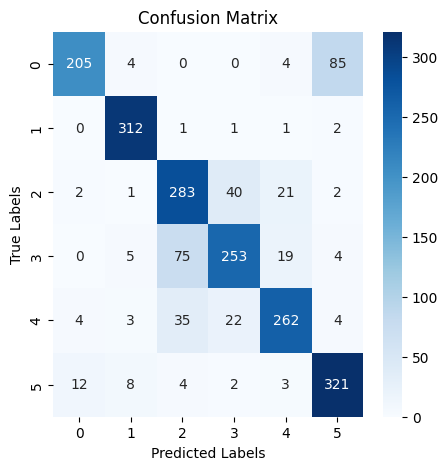

Classification Report:
              precision    recall  f1-score   support

     class_0       0.92      0.69      0.79       298
     class_1       0.94      0.98      0.96       317
     class_2       0.71      0.81      0.76       349
     class_3       0.80      0.71      0.75       356
     class_4       0.85      0.79      0.82       330
     class_5       0.77      0.92      0.84       350

    accuracy                           0.82      2000
   macro avg       0.83      0.82      0.82      2000
weighted avg       0.83      0.82      0.82      2000

Precision: 0.8250
Recall: 0.8180
F1-score: 0.8166
_____ _____ _____


63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 431ms/step - accuracy: 0.8228 - loss: 0.4873
loss is 0.4840382933616638
accuracy is 0.8180000185966492
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 430ms/step
(2000,)
_______________________________________________________________________


In [29]:
### get evaluation and confusion matrix with dense layers

models = {
     "VGG16": vgg16_architecture,
    #  "VGG19": vgg19_architecture,
    #  "ResNet152V2": resnet152v2_architecture,
    #  "InceptionV3": inception_v3_architecture,
    #  "DenseNet121": DenseNet121_architecture
}

for model_name, model_func in models.items():
    print(f"Training {model_name}...")
    model = model_func()
    model.fit(
        train_generator,
        validation_data=val_generator,
        epochs = 15  # Adjust epochs as needed
    )
    print(f"Evaluating {model_name}...")
    loss, accuracy = evaluate_model(model, xx_test, yy_test)
    print(f"{model_name} evaluation complete.")
    print(f"Accuracy: {accuracy}\n")
    print("_____ _____ _____")

    generate_confusion_matrix_and_metrics(model, xx_test, yy_test)
    print("_____ _____ _____")

    ## saving model
    model.save("D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/PRE_TRAINED_MODELS/VGG16_CNN_project.keras")
    model.save("D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/PRE_TRAINED_MODELS/VGG16_CNN_project.h5")
    xx_test_norm = xx_test/255    ## normalization
    loss,accuracy=model.evaluate(xx_test_norm,yy_test)
    print(f'loss is {loss}')
    print(f'accuracy is {accuracy}')

    ## getting predicton score (confidence level)
    yy_result = model.predict(xx_test_norm)
    # print(yy_result.shape)
    Indices_yy_result = np.argmax(yy_result , axis=1)
    # print(Indices_yy_result.shape)
    # print(Indices_yy_result)

    Score_yy_result =[]
    for i , index in enumerate(Indices_yy_result):
        Score_yy_result.append(yy_result[i][index])
    print(np.array(Score_yy_result).shape)
    print(f' The Predicton Score of 1st one is : {Score_y_result[0]*100:.2f}%')
    print("_______________________________________________________________________")




Training ResNet152V2...


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 106, 106,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 50, 50,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 52, 52,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 25, 25,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 25, 25,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 25, 25,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 25, 25,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 25, 25,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 25, 25,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 27, 27,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 25, 25,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 25, 25,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 25, 25,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 25, 25,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 25, 25,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 25, 25,    │          0 │ conv2_block1_0_c

 Total params: 58,899,590 (224.68 MB)

 Trainable params: 563,078 (2.15 MB)

 Non-trainable params: 58,336,512 (222.54 MB)

Epoch 1/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 207s 781ms/step - accuracy: 0.6241 - loss: 1.0903 - val_accuracy: 0.7275 - val_loss: 0.7206
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 188s 752ms/step - accuracy: 0.7267 - loss: 0.7348 - val_accuracy: 0.7690 - val_loss: 0.6463
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 190s 762ms/step - accuracy: 0.7469 - loss: 0.6647 - val_accuracy: 0.7575 - val_loss: 0.6435
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 194s 774ms/step - accuracy: 0.7676 - loss: 0.6269 - val_accuracy: 0.7745 - val_loss: 0.6077
Epoch 5/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 186s 744ms/step - accuracy: 0.7790 - loss: 0.5678 - val_accuracy: 0.7840 - val_loss: 0.5830
Epoch 6/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 187s 750ms/step - accuracy: 0.7832 - loss: 0.5578 - val_accuracy: 0.7920 - val_loss: 0.5629
Epoch 7/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 187s 748ms/step - accuracy: 0.7825 - loss: 0.5792 - val_accuracy: 0.7710 - val_loss: 0.6071
Epoch 8/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 187s 747ms/step - accuracy: 0.7815 -

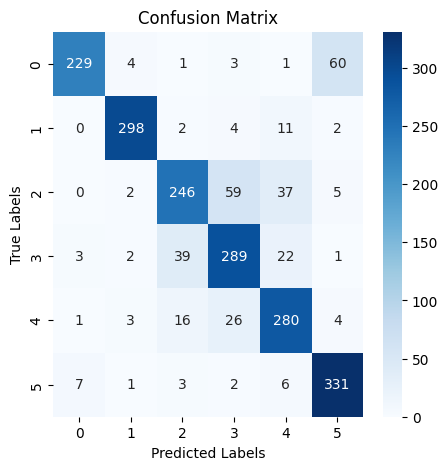

Classification Report:
              precision    recall  f1-score   support

     class_0       0.95      0.77      0.85       298
     class_1       0.96      0.94      0.95       317
     class_2       0.80      0.70      0.75       349
     class_3       0.75      0.81      0.78       356
     class_4       0.78      0.85      0.82       330
     class_5       0.82      0.95      0.88       350

    accuracy                           0.84      2000
   macro avg       0.85      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000

Precision: 0.8418
Recall: 0.8365
F1-score: 0.8360
_____ _____ _____


63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 581ms/step - accuracy: 0.8318 - loss: 0.4629
loss is 0.4567337930202484
accuracy is 0.8364999890327454
63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 578ms/step
(2000,)
_______________________________________________________________________


In [30]:
### get evaluation and confusion matrix with dense layers

models = {
    #  "VGG16": vgg16_architecture,
    #  "VGG19": vgg19_architecture,
     "ResNet152V2": resnet152v2_architecture,
    #  "InceptionV3": inception_v3_architecture,
    #  "DenseNet121": DenseNet121_architecture
}

for model_name, model_func in models.items():
    print(f"Training {model_name}...")
    model = model_func()
    model.fit(
        train_generator,
        validation_data=val_generator,
        epochs = 15  # Adjust epochs as needed
    )
    print(f"Evaluating {model_name}...")
    loss, accuracy = evaluate_model(model, xx_test, yy_test)
    print(f"{model_name} evaluation complete.")
    print(f"Accuracy: {accuracy}\n")
    print("_____ _____ _____")

    generate_confusion_matrix_and_metrics(model, xx_test, yy_test)
    print("_____ _____ _____")

    ## saving model
    model.save("D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/PRE_TRAINED_MODELS/ResNet152V2_CNN_project.keras")
    model.save("D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/PRE_TRAINED_MODELS/ResNet152V2_CNN_project.h5")
    xx_test_norm = xx_test/255    ## normalization
    loss,accuracy=model.evaluate(xx_test_norm,yy_test)
    print(f'loss is {loss}')
    print(f'accuracy is {accuracy}')

    ## getting predicton score (confidence level)
    yy_result = model.predict(xx_test_norm)
    # print(yy_result.shape)
    Indices_yy_result = np.argmax(yy_result , axis=1)
    # print(Indices_yy_result.shape)
    # print(Indices_yy_result)

    Score_yy_result =[]
    for i , index in enumerate(Indices_yy_result):
        Score_yy_result.append(yy_result[i][index])
    print(np.array(Score_yy_result).shape)
    print(f' The Predicton Score of 1st one is : {Score_y_result[0]*100:.2f}%')
    print("_______________________________________________________________________")




Training DenseNet121...


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 106, 106,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 50, 50,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 50, 50,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 50, 50,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 52, 52,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 25, 25,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 25, 25,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 25, 25,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 25, 25,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 25, 25,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 25, 25,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 25, 25,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 25, 25,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 25, 25,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 25, 25,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 25, 25,    │     12,288 │ conv2_block2_0_r

 Total params: 7,339,206 (28.00 MB)

 Trainable params: 298,886 (1.14 MB)

 Non-trainable params: 7,040,320 (26.86 MB)

Epoch 1/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 69s 237ms/step - accuracy: 0.6518 - loss: 0.9329 - val_accuracy: 0.7680 - val_loss: 0.6191
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 52s 208ms/step - accuracy: 0.7855 - loss: 0.5693 - val_accuracy: 0.8140 - val_loss: 0.5052
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 52s 206ms/step - accuracy: 0.8108 - loss: 0.4978 - val_accuracy: 0.8235 - val_loss: 0.4842
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 51s 205ms/step - accuracy: 0.8103 - loss: 0.5090 - val_accuracy: 0.8110 - val_loss: 0.4752
Epoch 5/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 51s 205ms/step - accuracy: 0.8133 - loss: 0.4880 - val_accuracy: 0.8320 - val_loss: 0.4611
Epoch 6/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 52s 207ms/step - accuracy: 0.8228 - loss: 0.4616 - val_accuracy: 0.8315 - val_loss: 0.4391
Epoch 7/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 51s 204ms/step - accuracy: 0.8287 - loss: 0.4606 - val_accuracy: 0.8370 - val_loss: 0.4488
Epoch 8/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 51s 204ms/step - accuracy: 0.8316 - loss: 0

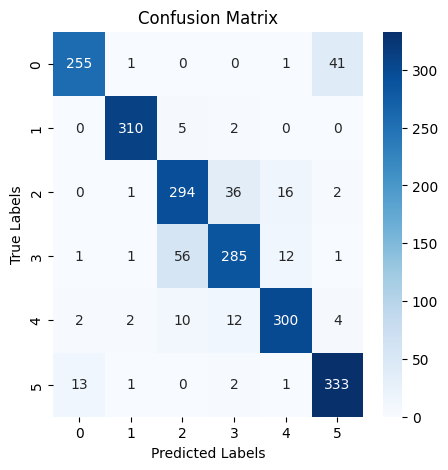

Classification Report:
              precision    recall  f1-score   support

     class_0       0.94      0.86      0.90       298
     class_1       0.98      0.98      0.98       317
     class_2       0.81      0.84      0.82       349
     class_3       0.85      0.80      0.82       356
     class_4       0.91      0.91      0.91       330
     class_5       0.87      0.95      0.91       350

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000

Precision: 0.8897
Recall: 0.8885
F1-score: 0.8883
_____ _____ _____


63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - accuracy: 0.8897 - loss: 0.2891
loss is 0.29546862840652466
accuracy is 0.8884999752044678
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step
(2000,)
_______________________________________________________________________


In [31]:
### get evaluation and confusion matrix with dense layers

models = {
    #  "VGG16": vgg16_architecture,
    #  "VGG19": vgg19_architecture,
    #  "ResNet152V2": resnet152v2_architecture,
    #  "InceptionV3": inception_v3_architecture,
     "DenseNet121": DenseNet121_architecture
}

for model_name, model_func in models.items():
    print(f"Training {model_name}...")
    model = model_func()
    model.fit(
        train_generator,
        validation_data=val_generator,
        epochs = 15  # Adjust epochs as needed
    )
    print(f"Evaluating {model_name}...")
    loss, accuracy = evaluate_model(model, xx_test, yy_test)
    print(f"{model_name} evaluation complete.")
    print(f"Accuracy: {accuracy}\n")
    print("_____ _____ _____")

    generate_confusion_matrix_and_metrics(model, xx_test, yy_test)
    print("_____ _____ _____")

    ## saving model
    model.save("D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/PRE_TRAINED_MODELS/DenseNet121_CNN_project.keras")
    model.save("D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/PRE_TRAINED_MODELS/DenseNet121_CNN_project.h5")
    xx_test_norm = xx_test/255    ## normalization
    loss,accuracy=model.evaluate(xx_test_norm,yy_test)
    print(f'loss is {loss}')
    print(f'accuracy is {accuracy}')

    ## getting predicton score (confidence level)
    yy_result = model.predict(xx_test_norm)


    
    # print(yy_result.shape)
    Indices_yy_result = np.argmax(yy_result , axis=1)
    # print(Indices_yy_result.shape)
    # print(Indices_yy_result)

    Score_yy_result =[]
    for i , index in enumerate(Indices_yy_result):
        Score_yy_result.append(yy_result[i][index])
    print(np.array(Score_yy_result).shape)
    print(f' The Predicton Score of 1st one is : {Score_y_result[0]*100:.2f}%')
    print("_______________________________________________________________________")




Training InceptionV3...


Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 49, 49,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 49,    │         96 │ conv2d_26[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 49, 49,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 47, 47,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 47, 47,    │         96 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 47, 47,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 47, 47,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 47, 47,    │        192 │ conv2d_28[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 47, 47,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 23, 23,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 23, 23,    │      5,120 │ max_pooling2d_10… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 23, 23,    │        240 │ conv2d_29[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 23, 23,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 21, 21,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 21, 21,    │        576 │ conv2d_30[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 21, 21,    │          0 │ batch_normalizat

 Total params: 22,362,534 (85.31 MB)

 Trainable params: 558,982 (2.13 MB)

 Non-trainable params: 21,803,552 (83.17 MB)

Epoch 1/10


c:\Users\ahmed\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 118ms/step - accuracy: 0.5328 - loss: 1.3021 - val_accuracy: 0.6315 - val_loss: 0.9566
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 131ms/step - accuracy: 0.6422 - loss: 0.9357 - val_accuracy: 0.6715 - val_loss: 0.8742
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 139ms/step - accuracy: 0.6695 - loss: 0.8851 - val_accuracy: 0.6850 - val_loss: 0.8458
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 140ms/step - accuracy: 0.6868 - loss: 0.8382 - val_accuracy: 0.6905 - val_loss: 0.8418
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 135ms/step - accuracy: 0.6807 - loss: 0.8267 - val_accuracy: 0.6815 - val_loss: 0.8214
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 142ms/step - accuracy: 0.6866 - loss: 0.8155 - val_accuracy: 0.6930 - val_loss: 0.8168
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 146ms/step - accuracy: 0.6793 - loss: 0.8165 - val_accuracy: 0.6835 - val_loss: 0.8213
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 154ms/step - accuracy: 0.6915 - loss: 0.8295 - val

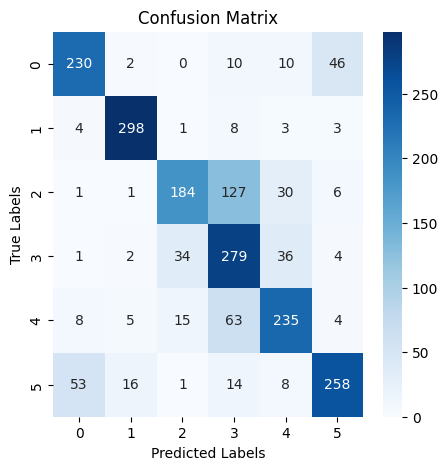

Classification Report:
              precision    recall  f1-score   support

     class_0       0.77      0.77      0.77       298
     class_1       0.92      0.94      0.93       317
     class_2       0.78      0.53      0.63       349
     class_3       0.56      0.78      0.65       356
     class_4       0.73      0.71      0.72       330
     class_5       0.80      0.74      0.77       350

    accuracy                           0.74      2000
   macro avg       0.76      0.75      0.75      2000
weighted avg       0.76      0.74      0.74      2000

Precision: 0.7580
Recall: 0.7420
F1-score: 0.7419
_____ _____ _____


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.7393 - loss: 0.6483
loss is 0.647205114364624
accuracy is 0.7419999837875366
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step
(2000,)
 The Predicton Score of 1st one is : 99.92%
_______________________________________________________________________


In [33]:
### get evaluation and confusion matrix with dense layers

models = {
    #  "VGG16": vgg16_architecture,
    #  "VGG19": vgg19_architecture,
    #  "ResNet152V2": resnet152v2_architecture,
     "InceptionV3": inception_v3_architecture,
    #  "DenseNet121": DenseNet121_architecture
}

for model_name, model_func in models.items():
    print(f"Training {model_name}...")
    model = model_func()
    model.fit(
        train_generator,
        validation_data=val_generator,
        epochs = 10  # Adjust epochs as needed
    )
    print(f"Evaluating {model_name}...")
    loss, accuracy = evaluate_model(model, xx_test, yy_test)
    print(f"{model_name} evaluation complete.")
    print(f"Accuracy: {accuracy}\n")
    print("_____ _____ _____")

    generate_confusion_matrix_and_metrics(model, xx_test, yy_test)
    print("_____ _____ _____")

    ## saving model
    model.save("D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/PRE_TRAINED_MODELS/InceptionV3_CNN_project.keras")
    model.save("D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/PRE_TRAINED_MODELS/InceptionV3_CNN_project.h5")
    xx_test_norm = xx_test/255    ## normalization
    loss,accuracy=model.evaluate(xx_test_norm,yy_test)
    print(f'loss is {loss}')
    print(f'accuracy is {accuracy}')

    ## getting predicton score (confidence level)
    yy_result = model.predict(xx_test_norm)


    
    # print(yy_result.shape)
    Indices_yy_result = np.argmax(yy_result , axis=1)
    # print(Indices_yy_result.shape)
    # print(Indices_yy_result)

    Score_yy_result =[]
    for i , index in enumerate(Indices_yy_result):
        Score_yy_result.append(yy_result[i][index])
    print(np.array(Score_yy_result).shape)
    print(f' The Predicton Score of 1st one is : {Score_y_result[0]*100:.2f}%')
    print("_______________________________________________________________________")




Training VGG19...


Model: "functional_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 100, 100, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 50, 50, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 25, 25, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_112         │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 20,192,966 (77.03 MB)

 Trainable params: 166,790 (651.52 KB)

 Non-trainable params: 20,026,176 (76.39 MB)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 188s 747ms/step - accuracy: 0.5677 - loss: 1.1802 - val_accuracy: 0.6375 - val_loss: 0.9353
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 186s 745ms/step - accuracy: 0.6777 - loss: 0.8340 - val_accuracy: 0.7095 - val_loss: 0.7358
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 216s 865ms/step - accuracy: 0.7040 - loss: 0.7757 - val_accuracy: 0.7180 - val_loss: 0.7209
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 237s 949ms/step - accuracy: 0.7139 - loss: 0.7601 - val_accuracy: 0.7025 - val_loss: 0.7639
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 201s 804ms/step - accuracy: 0.7261 - loss: 0.7314 - val_accuracy: 0.7275 - val_loss: 0.7083
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 197s 785ms/step - accuracy: 0.7199 - loss: 0.7322 - val_accuracy: 0.7295 - val_loss: 0.6847
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 183s 734ms/step - accuracy: 0.7324 - loss: 0.7041 - val_accuracy: 0.7275 - val_loss: 0.7072
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 184s 735ms/step - accuracy: 0.7231 -

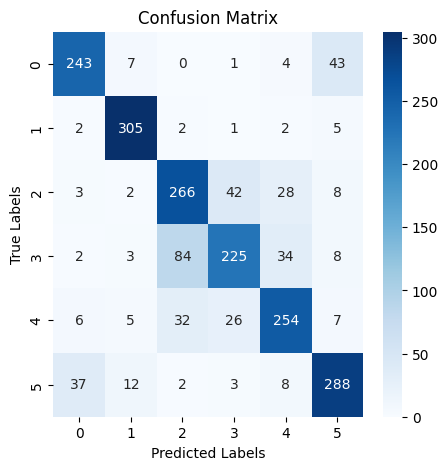

Classification Report:
              precision    recall  f1-score   support

     class_0       0.83      0.82      0.82       298
     class_1       0.91      0.96      0.94       317
     class_2       0.69      0.76      0.72       349
     class_3       0.76      0.63      0.69       356
     class_4       0.77      0.77      0.77       330
     class_5       0.80      0.82      0.81       350

    accuracy                           0.79      2000
   macro avg       0.79      0.79      0.79      2000
weighted avg       0.79      0.79      0.79      2000

Precision: 0.7903
Recall: 0.7905
F1-score: 0.7890
_____ _____ _____


63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 582ms/step - accuracy: 0.7913 - loss: 0.5393
loss is 0.5432418584823608
accuracy is 0.7904999852180481
63/63 ━━━━━━━━━━━━━━━━━━━━ 38s 609ms/step
(2000,)
 The Predicton Score of 1st one is : 99.92%
_______________________________________________________________________


In [34]:
### get evaluation and confusion matrix with dense layers

models = {
    #  "VGG16": vgg16_architecture,
     "VGG19": vgg19_architecture,
    #  "ResNet152V2": resnet152v2_architecture,
    #  "InceptionV3": inception_v3_architecture,
    #  "DenseNet121": DenseNet121_architecture
}

for model_name, model_func in models.items():
    print(f"Training {model_name}...")
    model = model_func()
    model.fit(
        train_generator,
        validation_data=val_generator,
        epochs = 10  # Adjust epochs as needed
    )
    print(f"Evaluating {model_name}...")
    loss, accuracy = evaluate_model(model, xx_test, yy_test)
    print(f"{model_name} evaluation complete.")
    print(f"Accuracy: {accuracy}\n")
    print("_____ _____ _____")

    generate_confusion_matrix_and_metrics(model, xx_test, yy_test)
    print("_____ _____ _____")

    ## saving model
    model.save("D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/PRE_TRAINED_MODELS/VGG19_CNN_project.keras")
    model.save("D:/Amit Data Science & AI/5 Computer Vision/Project_Comp.Vision/PRE_TRAINED_MODELS/VGG19_CNN_project.h5")
    xx_test_norm = xx_test/255    ## normalization
    loss,accuracy=model.evaluate(xx_test_norm,yy_test)
    print(f'loss is {loss}')
    print(f'accuracy is {accuracy}')

    ## getting predicton score (confidence level)
    yy_result = model.predict(xx_test_norm)


    
    # print(yy_result.shape)
    Indices_yy_result = np.argmax(yy_result , axis=1)
    # print(Indices_yy_result.shape)
    # print(Indices_yy_result)

    Score_yy_result =[]
    for i , index in enumerate(Indices_yy_result):
        Score_yy_result.append(yy_result[i][index])
    print(np.array(Score_yy_result).shape)
    print(f' The Predicton Score of 1st one is : {Score_y_result[0]*100:.2f}%')
    print("_______________________________________________________________________")




## In the code above, I have provided you with a written code, but it contains errors. Each of you must trace the errors and improve the accuracy for each model, recording the changes in the table below. Then, answer the following questions.

| Network          | Accuracy | Recall | Precision | F1-Score |
|------------------|----------|--------|-----------|----------|
| Your CNN model   |          |        |           |          |
| VGG16            |          |        |           |          |
| VGG19            |          |        |           |          |
| Inception_V3     |          |        |           |          |
| RasNet152V2      |          |        |           |          |
| DenseNet         |          |        |           |          |


# Experimental Results